# Init

In [1]:
output_path_render='renders/'
output_path_data='data_out/'
input_path_data='data_in/'

In [118]:
! pip install statsmodels fuzzywuzzy SPARQLWrapper python-Levenshtein "geopandas>=1.0.1" shapely geopy contextily folium titlecase fiona

In [3]:
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import numpy as np
from fuzzywuzzy import fuzz
import re
import seaborn as sns
from datetime import datetime, date
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, f_oneway, shapiro
from matplotlib.ticker import FixedLocator
from titlecase import titlecase

import statsmodels.api as sm
import math
import geopandas as gpd
from shapely import wkt
from geopy.distance import geodesic
from pyproj import Geod
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
from folium import FeatureGroup, LayerControl, Marker, Map
from folium.plugins import MarkerCluster
from jinja2 import Template
from folium.elements import MacroElement
from folium.features import CustomIcon
from folium.plugins import FeatureGroupSubGroup
from geopy.point import Point
from geopy.distance import distance as geodesic_distance
from shapely.geometry import Point as ShapelyPoint
import branca.colormap as cm_colormap

In [122]:
import pkg_resources

packages = [
    "SPARQLWrapper", "numpy", "fuzzywuzzy", "seaborn", "matplotlib", "pandas",
    "scipy", "titlecase", "statsmodels", "geopandas", "shapely", "geopy",
    "pyproj", "folium", "jinja2", "branca", "geopandas", "fiona"
]

requirements = []
for package in packages:
    try:
        version = pkg_resources.get_distribution(package).version
        requirements.append(f"{package}=={version}")
    except pkg_resources.DistributionNotFound:
        print(f"Warning: {package} is not installed in the current environment.")

with open("requirements.txt", "w") as f:
    f.write("\n".join(requirements))

print("requirements.txt was created successfully.")

requirements.txt was created successfully.


In [4]:
# SPARQL Query Function
def fetch_data_from_sparql(endpoint_url, query):
    """
    Fetch data from a SPARQL endpoint and return a pandas DataFrame.
    """
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setTimeout(600)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    data = []
    for result in results["results"]["bindings"]:
        row = {k: v["value"] for k, v in result.items()}
        data.append(row)
    return pd.DataFrame(data)

# SPARQL Queries
endpoint_url = "https://graph.dhi-roma.it/sparql" # "https://dataria.org/sparql"

In [148]:
# Global Params
event_count_threshold_nepotism=5
event_count_threshold_lead_speed=5
time_delta_threshold=293 # mean
distance_threshold=0
distance_log=False
time_diocese_lead_speed_agg='mean' # or 'median
speed_diocese_lead_speed_agg='mean' # or 'median
normalize_seasonality=False

# Nepotism

## Fetch Data

In [6]:
event_data_raw_nepotism = pd.DataFrame

### SPARQL

alternative statements for type container


```sparql
  {
    ?event grace:type_object ?midEntity .
  }
  UNION
  {
    ?event grace:object_object ?b .
    ?b grace:type_object ?midEntity .
  }
  UNION
  {
    ?event grace:object_object+ ?b .
    ?b a grace:benefice ;
       grace:type_object ?midEntity .
  }
  ?midEntity (grace:broader*) ?entity .
```

In [7]:
#@title Extensive Query

# Query for events
events_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX grace: <https://g17.dhi-roma.it/ontology/>
PREFIX g17raw: <https://g17.dhi-roma.it/raw/>
PREFIX g17: <https://g17.dhi-roma.it/resources/>

SELECT DISTINCT ?event ?event_label ?span_text ?label ?person ?element ?role_label
  ?role ?family_name ?given_name ?family_members ?institution ?institution_label ?date
  (GROUP_CONCAT(DISTINCT ?type_label; SEPARATOR = ",") AS ?type_labels)
WHERE {
  # Filter expedit 2 and 9
  ?event rdf:type grace:event ;
         grace:called ?event_label ;
         grace:testified_by ?ENTRY_2 .
  ?ENTRY_2 rdf:type grace:entry ;
           grace:in_source ?SOURCE_4 .
  VALUES ?SOURCE_4 { g17:source_1 g17:source_2 }
  ?event g17raw:is_described_by ?element .
  ?element g17raw:span_text ?span_text ;
           g17raw:has_label ?label .
  ?label g17raw:has_class grace:person ;
         g17raw:has_main_property ?role .
  ?role grace:called ?role_label .
  FILTER (?role != g17:type_1119) # exclude authorities
    # Institution:
  ?event (grace:object_object|^grace:event_object)*/grace:in_diocese ?institution .
  ?institution rdf:type grace:diocese ;
               grace:called ?institution_label .
   # Type Labels:
  ?event ((grace:type_object|(grace:object_object|^grace:object_related_to_event)+/grace:type_object)/grace:broader*) ?entity .
  ?entity a grace:term .
  FILTER(NOT EXISTS { ?entity grace:in_thesaurus ?thesaurus.
      VALUES ?thesaurus {
        g17:type_459 # type of object
        # g17:type_142 # subtype of event
        g17:type_50 # exclude types of subregister
      }. })
  ?entity grace:called ?type_label .
  OPTIONAL {
    {
      SELECT ?event (SAMPLE(?d) AS ?date)
      WHERE {
        ?event grace:event_date ?date_2 .
        ?date_2 rdf:type grace:date ;
                grace:started ?d .
      }
      GROUP BY ?event
    }
    FILTER (?event = ?event)
  }
  OPTIONAL {
    {
      SELECT ?element ?person (SAMPLE(?fn) AS ?family_name) (SAMPLE(?gn) AS ?given_name)
  (GROUP_CONCAT(DISTINCT ?fm_name; SEPARATOR = ",") AS ?family_members)
      WHERE {
        ?element g17raw:entity ?person .
        ?person a grace:natural_person .
        OPTIONAL {
          ?person grace:family_name ?fn .
        }
        OPTIONAL {
          ?person grace:given_name ?gn .
        }
        OPTIONAL {
          ?person (grace:kinship|^grace:kinship)* ?family_member .
        }
      }
      GROUP BY ?element ?person
    }
    FILTER (?element = ?element)
  }
}
GROUP BY ?event ?event_label ?span_text ?label ?role_label ?role ?element ?person
  ?date ?family_name ?given_name ?family_members ?institution_label ?institution
"""
try:
  event_data_raw_nepotism = fetch_data_from_sparql(endpoint_url, events_query)
  print(len(event_data_raw_nepotism))
except Exception as e:
  print(e)


14932


### CSV

In [8]:
if event_data_raw_nepotism.empty:
  print("use CSV!")
  event_data_raw_nepotism = pd.read_csv(input_path_data + 'Nepotism.csv')

### Post Process

In [9]:
df=event_data_raw_nepotism.copy()

In [10]:
# Ensure that optional fields are filled with empty strings if they are missing

optional_fields = [
    'person', 'element', 'family_members', 'family_name', 'given_name', 'span_text', 'label', 'role_label', 'type_labels', 'date'
]
for field in optional_fields:
    if field not in df.columns:
        df[field] = ''  # Add the column if it's missing
    else:
        df[field] = df[field].fillna('')  # Fill NaN values with empty strings

# Replace empty strings with NaN in specified columns
df['family_name'] = df['family_name'].replace('', np.nan)
df['span_text'] = df['span_text'].replace('', np.nan)
df['label'] = df['label'].replace('', np.nan)

# Use 'person' as 'person_id' directly
df['person_id'] = df['person'].fillna(df['element']).astype(str)

# Ensure 'related_to' is 'family_member' (if exists), using their IRIs
def parse_related_to(family_member):
    if not family_member.strip():
        return []
    # Split by commas or semicolons and strip whitespace
    return [rel.strip().lower() for rel in re.split('[,;]', family_member) if rel.strip()]

df['related_to'] = df['family_members'].apply(parse_related_to)

# Populate 'name' by prioritizing 'family_name', 'span_text', 'label'
df['name'] = df['family_name'].fillna(df['span_text']).fillna('')

# Ensure 'given_name' is available
df['given_name'] = df['given_name'].astype(str)

# Convert NaN back to empty strings if needed (optional)
df['family_name'] = df['family_name'].fillna('')
df['span_text'] = df['span_text'].fillna('')
df['label'] = df['label'].fillna('')

# Now, process each event
events = df['event'].unique()

In [11]:
df.head()

,event,event_label,span_text,label,element,role_label,role,institution,institution_label,date,type_labels,person,family_name,given_name,family_members,person_id,related_to,name
0,https://g17.dhi-roma.it/resources/event_3462,APOSTOLIC PROVISION 3462,Antonius Balma,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_62974,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_551,Taranthasiensis,1678-01-25T00:00:00Z,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius Balma
1,https://g17.dhi-roma.it/resources/event_4052,APOSTOLIC PROVISION 4052,Antonius de Rabana,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_71408,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_246,Elnensis,1622-06-13T00:00:00Z,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius de Rabana
2,https://g17.dhi-roma.it/resources/event_6932,APOSTOLIC PROVISION 6932,Petrus Paulus Xara,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_105638,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_723,Melevitana,,"apostolic provision,papal grace,death of previ...",,,,,,[],Petrus Paulus Xara
3,https://g17.dhi-roma.it/resources/event_5805,APOSTOLIC PROVISION 5805,Ovidi Castellani,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_92698,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_292,Hieracensis,1622-05-30T00:00:00Z,"deceased in Rome,apostolic provision,papal gra...",,,,,,[],Ovidi Castellani
4,https://g17.dhi-roma.it/resources/event_7911,APOSTOLIC PROVISION 7911,Ludovici Iannier,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_114397,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_620,Venetensis,1622-09-05T00:00:00Z,"apostolic provision,papal grace,death of previ...",,,,,,[],Ludovici Iannier


In [12]:
print(len(df))

14932


## Parsing

### Date

In [13]:
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ').date()
    except (ValueError, TypeError):
        return None

if 'date' in df.columns:
    df['date'] = df['date'].apply(parse_date)

df.head()

,event,event_label,span_text,label,element,role_label,role,institution,institution_label,date,type_labels,person,family_name,given_name,family_members,person_id,related_to,name
0,https://g17.dhi-roma.it/resources/event_3462,APOSTOLIC PROVISION 3462,Antonius Balma,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_62974,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_551,Taranthasiensis,1678-01-25,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius Balma
1,https://g17.dhi-roma.it/resources/event_4052,APOSTOLIC PROVISION 4052,Antonius de Rabana,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_71408,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_246,Elnensis,1622-06-13,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius de Rabana
2,https://g17.dhi-roma.it/resources/event_6932,APOSTOLIC PROVISION 6932,Petrus Paulus Xara,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_105638,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_723,Melevitana,None,"apostolic provision,papal grace,death of previ...",,,,,,[],Petrus Paulus Xara
3,https://g17.dhi-roma.it/resources/event_5805,APOSTOLIC PROVISION 5805,Ovidi Castellani,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_92698,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_292,Hieracensis,1622-05-30,"deceased in Rome,apostolic provision,papal gra...",,,,,,[],Ovidi Castellani
4,https://g17.dhi-roma.it/resources/event_7911,APOSTOLIC PROVISION 7911,Ludovici Iannier,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_114397,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_620,Venetensis,1622-09-05,"apostolic provision,papal grace,death of previ...",,,,,,[],Ludovici Iannier


## Nepotism Functions

### Helpers

In [14]:
# Adjusted split_person_name function

def split_person_name(input_name, params=None):
    if not input_name:
        return None

    default_params = {"particles": ["de"], "stopwords": [r'\bpresbit', r'\betiam\b', r'\bunknown\b', r'\bsenio\w+\b', r'\b[ji]unio\w+\b']}
    if params:
        default_params.update(params)

    input_name = input_name.strip().lower()
    if not input_name or " " not in input_name:
        return None

    name_parts = input_name.split()
    stopwords = default_params["stopwords"]
    particles = default_params["particles"]

    stopwords_pattern = [re.compile(word, re.IGNORECASE) for word in stopwords]


    filtered_names = [
        part for part in name_parts
        if not any(pattern.search(part) for pattern in stopwords_pattern)
    ]

    cleaned_names = [
        part.capitalize() if part not in particles else part
        for part in filtered_names
    ]

    if not cleaned_names:
        return None

    return {
        "components": cleaned_names,
        "given_name": cleaned_names[0],
        "name": " ".join(cleaned_names[1:]) if len(cleaned_names) > 1 else "",
        "given_name_alt": " ".join(cleaned_names[:-1]) if len(cleaned_names) > 1 else "",
        "name_alt": cleaned_names[-1] if len(cleaned_names) > 1 else "",
        "params": default_params,
    }

# Function to determine the name used for comparison
def get_name_for_comparison(person, params=None):
    """
    Return the name to be used for comparison.
    If 'given_name' is not empty, use 'family_name'.
    Otherwise, use split_person_name on 'family_name' or 'span_text'.
    """
    if person.get("given_name"):
        return person.get("family_name", "")
    else:
        name_source = person.get("family_name") or person.get("span_text") or ""
        name_info = split_person_name(name_source, params)
        if name_info:
            return name_info["name_alt"]
        else:
            return ""

# Family name frequency calculator
def family_name_frequency(family_name, person_data, params=None):
    """
    Calculation of the frequency of a surname over all persons in the dataset using fuzzy matching.
    The function extracts the names with get_name_for_comparison and compares them with the given surname.
    """
    default_params = {"threshold": 0.6}
    if params:
        default_params.update(params)
    threshold = default_params["threshold"]
    family_name = family_name.lower()
    # Extract the names with get_name_for_comparison
    matches = person_data['extracted_name'].dropna().str.lower().apply(
        lambda x: fuzz.ratio(family_name, x) / 100 >= threshold
    )
    return matches.sum()

In [15]:
split_person_name("Laurentii Sardonii Senioris")

{'components': ['Laurentii', 'Sardonii'],
 'given_name': 'Laurentii',
 'name': 'Sardonii',
 'given_name_alt': 'Laurentii',
 'name_alt': 'Sardonii',
 'params': {'particles': ['de'],
  'stopwords': ['\\bpresbit',
   '\\betiam\\b',
   '\\bunknown\\b',
   '\\bsenio\\w+\\b',
   '\\b[ji]unio\\w+\\b']}}

### Main Function

In [16]:
def calculate_nepotism(event_id, persons_in_event, person_data, params=None):
    """
    Calculate the nepotism probability between pairs of persons in an event.

    Args:
        event_id (str): Identifier for the event.
        persons_in_event (pd.DataFrame): DataFrame containing persons involved in the event.
        person_data (pd.DataFrame): DataFrame containing additional person data.
        params (dict, optional): Dictionary of parameters to override defaults.

    Returns:
        pd.DataFrame: DataFrame containing nepotism probability results.
    """
    # Define default parameters
    default_params = {
        "f1": 1.0,  # Highest confidence level
        "f2": 0.7,  # Medium confidence level
        "f3": 0.5,  # Lowest confidence level
        "t1": 0.6,  # Threshold for fuzzy matching
        "signal_words": [r"\betiam\b", r"\bsenior\b", r"\b[ji]unior\b"],
        "verbose": False  # Control for debugging output
    }

    # Update default parameters with any provided parameters
    if params:
        default_params.update(params)

    if 'extracted_name' not in person_data.columns:
        person_data['extracted_name'] = person_data.apply(get_name_for_comparison, axis=1)

    results = []
    persons_in_event = persons_in_event.reset_index(drop=True)

    # Compile signal words patterns with word boundaries for accurate matching
    signal_patterns = [re.compile(word, re.IGNORECASE) for word in default_params["signal_words"]]

    # Extract diocese information if available
    if not persons_in_event.empty:
        diocese_id = persons_in_event['institution'].iloc[0] if 'institution' in persons_in_event.columns else ''
        diocese_name = persons_in_event['institution_label'].iloc[0] if 'institution_label' in persons_in_event.columns else ''
        event_date = persons_in_event['date'].iloc[0] if 'date' in persons_in_event.columns else ''
        type_labels = persons_in_event['type_labels'].iloc[0] if 'type_labels' in persons_in_event.columns else ''
    else:
        diocese_id = ''
        diocese_name = ''
        type_labels = ''
        event_date = ''

    # Conditional debug prints
    if default_params["verbose"]:
        print("Initial default_params:", default_params)
        print("Persons in event after reset_index:")
        print(persons_in_event)
        print("Compiled signal_patterns:", [pattern.pattern for pattern in signal_patterns])
        print(f"Diocese ID: '{diocese_id}', Diocese Name: '{diocese_name}'")

    # Iterate over all unique pairs of persons in the event
    for i in range(len(persons_in_event)):
        person1 = persons_in_event.loc[i]

        if default_params["verbose"]:
            print(f"\nProcessing Person1 (Index {i}):")
            print(person1)

        for j in range(i + 1, len(persons_in_event)):
            person2 = persons_in_event.loc[j]

            if default_params["verbose"]:
                print(f"\nProcessing Person2 (Index {j}):")
                print(person2)

            # Skip comparison if both entries refer to the same person and person_id is not empty
            if person1["person_id"] == person2["person_id"] and person1["person_id"] != '':
                if default_params["verbose"]:
                    print("Same person detected. Skipping comparison.")
                continue

            # Retrieve names for comparison
            name1_alt = get_name_for_comparison(person1)
            name2_alt = get_name_for_comparison(person2)

            if default_params["verbose"]:
                print(f"Name1 for comparison: '{name1_alt}', Name2 for comparison: '{name2_alt}'")

            # Skip comparison if either name is missing
            if not name1_alt or not name2_alt:
                if default_params["verbose"]:
                    print("One of the names for comparison is missing. Skipping comparison.")
                continue

            # Check if both names are at least 4 characters long
            if len(name1_alt) < 4 or len(name2_alt) < 4:
                if default_params["verbose"]:
                    print(f"One of the names is shorter than 4 characters (Name1: '{name1_alt}', Name2: '{name2_alt}'). Skipping comparison.")
                continue

            # Calculate the fuzzy matching score of the family names
            ratio_score = fuzz.ratio(name1_alt.lower(), name2_alt.lower()) / 100

            if default_params["verbose"]:
                print(f"Initial ratio_score (fuzz.ratio): {ratio_score}")

            # Adjust ratio_score based on threshold
            if ratio_score <= default_params["t1"]:
                if default_params["verbose"]:
                    print(f"ratio_score {ratio_score} is below threshold {default_params['t1']}. Setting to 0.")
                ratio_score = 0
            else:
                if default_params["verbose"]:
                    print(f"ratio_score {ratio_score} is above or equal to threshold {default_params['t1']}.")

            # Initialize confidence with the lowest confidence level (f3)
            confidence = default_params["f3"]
            if default_params["verbose"]:
                print(f"Initial confidence set to f3: {confidence}")

            # Check if the persons are related (related_to)
            related_to_person1 = person1.get("related_to", [])
            related_to_person2 = person2.get("related_to", [])

            if default_params["verbose"]:
                print(f"related_to_person1: {related_to_person1}, related_to_person2: {related_to_person2}")

            # Compare 'person_id' of the other person with the 'related_to' list
            is_related = (
                person2["person_id"].strip().lower() in [id.lower() for id in related_to_person1]
                or person1["person_id"].strip().lower() in [id.lower() for id in related_to_person2]
            )

            if default_params["verbose"]:
                print(f"is_related: {is_related}")

            # Check for the presence of signal words in the combined span_text
            span_text_combined = (
                person1.get("span_text", "") + " " + person2.get("span_text", "")
            ).lower()

            if default_params["verbose"]:
                print(f"span_text_combined: '{span_text_combined}'")

            # Use the precompiled regex patterns
            has_signal_word = any(pattern.search(span_text_combined) for pattern in signal_patterns)

            if default_params["verbose"]:
                print(f"has_signal_word: {has_signal_word}")

            # Further debug output for verification
            if default_params["verbose"]:
                print(f"Comparing Person {person1['person_id']} and Person {person2['person_id']}")
                print(f"Is Related: {is_related}, Has Signal Word: {has_signal_word}, Span Text Combined: '{span_text_combined}'")

            # Adjust confidence and ratio_score based on relationships or signal words
            if is_related or has_signal_word:
                confidence = default_params["f1"]
                if is_related:
                  ratio_score = 1  # Set score to 1 as supervised
                if default_params["verbose"]:
                    print(f"Set confidence to f1 ({default_params['f1']}) and ratio_score to 1")
            else:
                # Check if both persons have given names
                given_name1 = person1.get("given_name", "").strip()
                given_name2 = person2.get("given_name", "").strip()
                given_names_present = bool(given_name1) and bool(given_name2)

                if default_params["verbose"]:
                    print(f"given_name1: '{given_name1}', given_name2: '{given_name2}', given_names_present: {given_names_present}")

                if given_names_present:
                    confidence = default_params["f2"]
                    if default_params["verbose"]:
                        print(f"Set confidence to f2 ({default_params['f2']})")
                else:
                    if default_params["verbose"]:
                        print(f"Set confidence to f3 ({default_params['f3']})")

            # Calculate the frequency of the family name in person_data
            name_frequency = family_name_frequency(
                name1_alt, person_data, {"threshold": default_params["t1"]}
            )

            if default_params["verbose"]:
                print(f"name_frequency for '{name1_alt}': {name_frequency}")

            # Compute the combined score
            combined_score = ratio_score * confidence

            if default_params["verbose"]:
                print(f"Combined score (ratio_score * confidence): {combined_score}")

            # Create the result dictionary
            result = {
                "event_id": event_id,
                "person1_id": person1["person_id"],
                "person2_id": person2["person_id"],
                "person1_span_text": person1.get("span_text", ""),
                "person2_span_text": person2.get("span_text", ""),
                "extracted_name1": name1_alt,
                "extracted_name2": name2_alt,
                "person1_role": person1.get("role_label", ""),
                "person2_role": person2.get("role_label", ""),
                "ratio_score": ratio_score,
                "diocese_id": diocese_id,
                "diocese_name": diocese_name,
                "type_labels": type_labels,
                "date": event_date,
                "confidence": confidence,
                "combined_score": combined_score,
                "name_frequency": name_frequency,
            }

            if default_params["verbose"]:
                print("Appending result:", result)

            # Append the result to the results list
            results.append(result)

    # Convert the results list to a DataFrame
    df_results = pd.DataFrame(results)

    if default_params["verbose"]:
        print("\nFinal Results DataFrame:")
        print(df_results)

    return df_results

## Parameters and Data Check

In [17]:
nepotism_params = {
        "f1": 1.0,  # established by data or signal word
        "f2": 0.7,  # supervised split names
        "f3": 0.5,  # unsupervised split names
        "t1": 0.6,  # Threshold for fuzzy matching
        "signal_words": [r"\betiam\b", r"\bsenior\b", r"\b[ji]unior\b"]    }

In [18]:
print(len(event_data_raw_nepotism))

14932


In [19]:
df.head(10)

,event,event_label,span_text,label,element,role_label,role,institution,institution_label,date,type_labels,person,family_name,given_name,family_members,person_id,related_to,name
0,https://g17.dhi-roma.it/resources/event_3462,APOSTOLIC PROVISION 3462,Antonius Balma,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_62974,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_551,Taranthasiensis,1678-01-25,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius Balma
1,https://g17.dhi-roma.it/resources/event_4052,APOSTOLIC PROVISION 4052,Antonius de Rabana,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_71408,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_246,Elnensis,1622-06-13,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius de Rabana
2,https://g17.dhi-roma.it/resources/event_6932,APOSTOLIC PROVISION 6932,Petrus Paulus Xara,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_105638,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_723,Melevitana,None,"apostolic provision,papal grace,death of previ...",,,,,,[],Petrus Paulus Xara
3,https://g17.dhi-roma.it/resources/event_5805,APOSTOLIC PROVISION 5805,Ovidi Castellani,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_92698,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_292,Hieracensis,1622-05-30,"deceased in Rome,apostolic provision,papal gra...",,,,,,[],Ovidi Castellani
4,https://g17.dhi-roma.it/resources/event_7911,APOSTOLIC PROVISION 7911,Ludovici Iannier,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_114397,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_620,Venetensis,1622-09-05,"apostolic provision,papal grace,death of previ...",,,,,,[],Ludovici Iannier
5,https://g17.dhi-roma.it/resources/event_400,APOSTOLIC PROVISION 400,Vincentius de Bardis,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_27814,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_92,Aversana,1622-10-24,"apostolic provision,papal grace,death of previ...",,,,,,[],Vincentius de Bardis
6,https://g17.dhi-roma.it/resources/event_7586,APOSTOLIC PROVISION 7586,Antonius Sbert,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_34168,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_375,Messanensis,1622-12-01,"apostolic provision,papal grace,death of previ...",,,,,,[],Antonius Sbert
7,https://g17.dhi-roma.it/resources/event_9359,APOSTOLIC PROVISION 9359,Claudius Perrex,https://g17.dhi-roma.it/raw/label_158,https://g17.dhi-roma.it/raw/element_128408,providee,https://g17.dhi-roma.it/resources/type_68,https://g17.dhi-roma.it/resources/institution_276,Gebennensis,1678-01-23,"apostolic provision,papal grace",,,,,,[],Claudius Perrex
8,https://g17.dhi-roma.it/resources/event_4655,APOSTOLIC PROVISION 4655,Francisci Cortes,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_79389,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_529,Seguntin,1623-02-07,"apostolic provision,papal grace,death of previ...",,,,,,[],Francisci Cortes
9,https://g17.dhi-roma.it/resources/event_9170,APOSTOLIC PROVISION 9170,Petri du Cluzeau,https://g17.dhi-roma.it/raw/label_159,https://g17.dhi-roma.it/raw/element_126668,former possessor,https://g17.dhi-roma.it/resources/type_97,https://g17.dhi-roma.it/resources/institution_327,Lemovicensis,1678-01-02,"apostolic provision,papal grace",,,,,,[],Petri du Cluzeau


## Calculate Nepotism

In [20]:
results_list = []
df['extracted_name'] = df.apply(get_name_for_comparison, axis=1)

for event_id in events:
    persons_in_event = df[df['event'] == event_id]
    if len(persons_in_event) < 2:
        continue  # No pairs to compare

    nepotism_df = calculate_nepotism(event_id, persons_in_event, df, nepotism_params)
    if not nepotism_df.empty:
        results_list.append(nepotism_df)

# Combine results
if results_list:
    final_results = pd.concat(results_list, ignore_index=True)
else:
    final_results = pd.DataFrame()

### Data Checks and Insights

In [21]:
print(len(final_results))

7097


In [22]:
# Calculate mean and standard deviation
mean_ratio = final_results["combined_score"].mean()
std_dev_ratio = final_results["combined_score"].std()

# Define thresholds
low_threshold = mean_ratio - std_dev_ratio
high_threshold = mean_ratio + std_dev_ratio
significant_threshold = mean_ratio + 2 * std_dev_ratio

# Analyze each event
final_results["likelihood"] = final_results["combined_score"].apply(
    lambda x: "significant" if x >= significant_threshold else
              "high" if x >= high_threshold else
              "low" if x <= low_threshold else
              "typical"
)

print("Mean Ratio:", mean_ratio)
print("Standard Deviation:", std_dev_ratio)
final_results.sort_values(by='combined_score', ascending=False, inplace=True)
final_results.to_csv(output_path_data + "events_nepotism.csv")
final_results.head(1100)

Mean Ratio: 0.05209990136677469
Standard Deviation: 0.17692057011529955


,event_id,person1_id,person2_id,person1_span_text,person2_span_text,extracted_name1,extracted_name2,person1_role,person2_role,ratio_score,diocese_id,diocese_name,type_labels,date,confidence,combined_score,name_frequency,likelihood
1568,https://g17.dhi-roma.it/resources/event_8798,,,Mathurini etiam Dupin,Ludovicus Dupin,Dupin,Dupin,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_50,Andegavensis,"apostolic provision,papal grace",1677-12-12,1.0,1.0,95,significant
5762,https://g17.dhi-roma.it/resources/event_8279,,,Stephani etiam comendatarii du Flocquet,Franciscus du Flocquet,Flocquet,Flocquet,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_192,Claromontensis,"Placing a commenda,apostolic provision,papal g...",1677-10-23,1.0,1.0,62,significant
2557,https://g17.dhi-roma.it/resources/event_149,,,Alexius Oliverii,Jois Baptistae etiam Oliverii,Oliverii,Oliverii,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_423,Nucerina,"Resignation,apostolic provision,papal grace,ch...",1678-09-02,1.0,1.0,107,significant
5790,https://g17.dhi-roma.it/resources/event_2658,,,Francisci etiam Garnier,Joannes Garnier,Garnier,Garnier,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_589,Turonensis,"Placing a commenda,apostolic provision,papal g...",1678-07-08,1.0,1.0,241,significant
5775,https://g17.dhi-roma.it/resources/event_4192,,,Joannis Munoz de Aguilar Senioris,Joannes Munoz de Aguilar Junior,Aguilar,Aguilar,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_324,Legionensis,"Resignation,apostolic provision,papal grace,Ca...",1623-02-07,1.0,1.0,130,significant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,https://g17.dhi-roma.it/resources/event_3972,,,Ioannes Ordege,Francisci Ferrie,Ordege,Ferrie,providee,former possessor,0.0,https://g17.dhi-roma.it/resources/institution_99,Barchinonensis,"apostolic provision,papal grace,death of previ...",1622-04-09,0.5,0.0,47,typical
4991,https://g17.dhi-roma.it/resources/event_8377,,,Antonii Proquea,Jacobus Lebrun,Proquea,Lebrun,former possessor,providee,0.0,https://g17.dhi-roma.it/resources/institution_532,Senonensis,"apostolic provision,papal grace",None,0.5,0.0,76,typical
4990,https://g17.dhi-roma.it/resources/event_3063,,,Antonius Carletus,Joannis de Sacchis,Carletus,Sacchis,providee,former possessor,0.0,https://g17.dhi-roma.it/resources/institution_460,Placentina provinciae Bononiensis,"Resignation,apostolic provision,papal grace,Re...",1622-02-25,0.5,0.0,318,typical
6870,https://g17.dhi-roma.it/resources/event_4391,,,Christophorus Caetanus,Christophori Vegli,Caetanus,Vegli,providee,former possessor,0.0,https://g17.dhi-roma.it/resources/institution_48,Anagnina,"deceased in Rome,apostolic provision,papal gra...",1622-05-05,0.5,0.0,345,typical


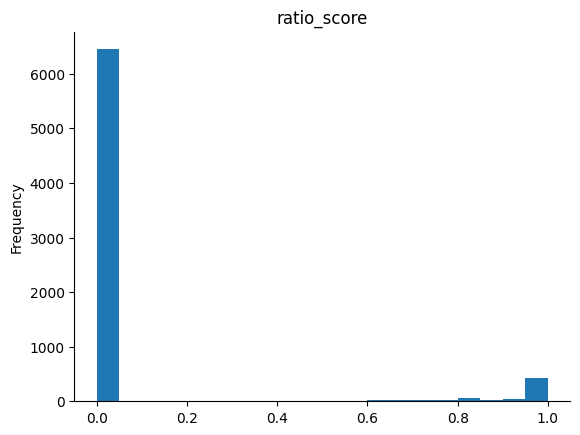

In [23]:
from matplotlib import pyplot as plt
final_results['ratio_score'].plot(kind='hist', bins=20, title='ratio_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

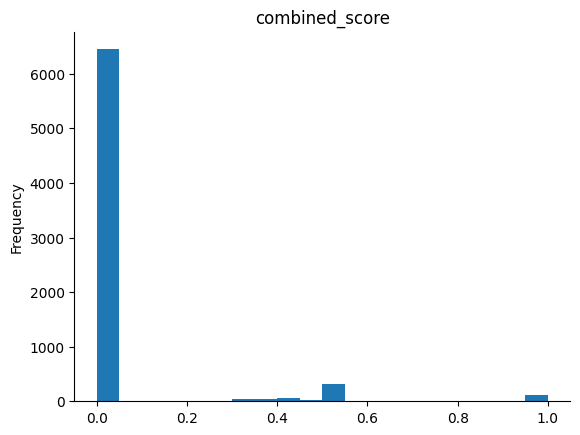

In [24]:
from matplotlib import pyplot as plt
final_results['combined_score'].plot(kind='hist', bins=20, title='combined_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Correlations

In [25]:
dep_var="combined_score"

### Confidence vs. Ratio Score

This shows that similar family names correlate with kinship

In [26]:
if 'ratio_score' in final_results.columns and 'confidence' in final_results.columns:
    correlation, p_val = pearsonr(final_results['ratio_score'],(final_results['confidence']))

    print(f"Correlation between 'ratio_score' and 'confidence': {correlation}, {p_val}")
    correlation, p_val = pearsonr(final_results['combined_score'],(final_results['confidence']))
    print(f"Correlation between 'combined_score' and 'confidence': {correlation}, {p_val}")
    correlation, p_val = pearsonr(final_results['combined_score'],(final_results['name_frequency']))
    print(f"Correlation between 'combined_score' and 'name_frequency': {correlation}, {p_val}")


Correlation between 'ratio_score' and 'confidence': 0.332207497132294, 1.9459322430032334e-182
Correlation between 'combined_score' and 'confidence': 0.5400441416792252, 0.0
Correlation between 'combined_score' and 'name_frequency': -0.04462783895626065, 0.00016935358227875529


In [27]:
adjusted_df = final_results.copy()

# Set all values from confidence < 1 to 0
adjusted_df['confidence'] = adjusted_df['confidence'].apply(lambda x: 1 if x == 1 else 0)

if 'ratio_score' in adjusted_df.columns:
    correlation, p_val = pearsonr(adjusted_df['ratio_score'],(adjusted_df['confidence']))
    print(f"Correlation between 'ratio_score' and 'confidence=1': {correlation}, {p_val}")
    correlation, p_val = pearsonr(adjusted_df['combined_score'],(adjusted_df['confidence']))
    print(f"Correlation between 'combined_score' and 'confidence=1': {correlation}, {p_val}")

Correlation between 'ratio_score' and 'confidence=1': 0.33143316807958706, 1.5128765043801083e-181
Correlation between 'combined_score' and 'confidence=1': 0.5393721485436547, 0.0


### Types vs. Combined Score

In [28]:
type_dummies = final_results['type_labels'].str.get_dummies(sep=',')
df_with_dummies = pd.concat([final_results, type_dummies], axis=1)
# Initialize a dictionary to store the correlations
correlations = {}

# Iterate over each category column and calculate the correlation
for column in type_dummies.columns:
    correlation, p_val = pearsonr(df_with_dummies[column], df_with_dummies[dep_var])
    correlations[column] = {'Correlation': correlation, 'P-Value': p_val}

# Convert the dictionary into a DataFrame for a clear presentation
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).dropna()

# Select the top and bottom 10 correlations (including p-values)
top_bottom_df = pd.concat([correlation_df.head(10), correlation_df.tail(10)])

# Print the result
print(top_bottom_df)

                                   Correlation       P-Value
Resignation                           0.164385  3.574566e-44
Receiver of an additional payment     0.089961  3.133090e-14
Major church                          0.040300  6.842783e-04
Pastor                                0.029845  1.192578e-02
Placing a commenda                    0.029674  1.242142e-02
Collegiate church                     0.026980  2.303215e-02
Parish and collegiate church          0.026565  2.522416e-02
Motu proprio                          0.024360  4.016042e-02
Reservation of a pension              0.023792  4.503857e-02
Mistake                               0.022198  6.148730e-02
Replacement                          -0.020433  8.520812e-02
Cantorate                            -0.021320  7.250004e-02
Referral to a higher authority       -0.022389  5.928643e-02
Holder of prestimony                 -0.023787  4.508620e-02
Sacristan                            -0.024556  3.858179e-02
Curate                  

c:\Users\c.sander\AppData\Local\miniconda3\envs\Graceful17\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


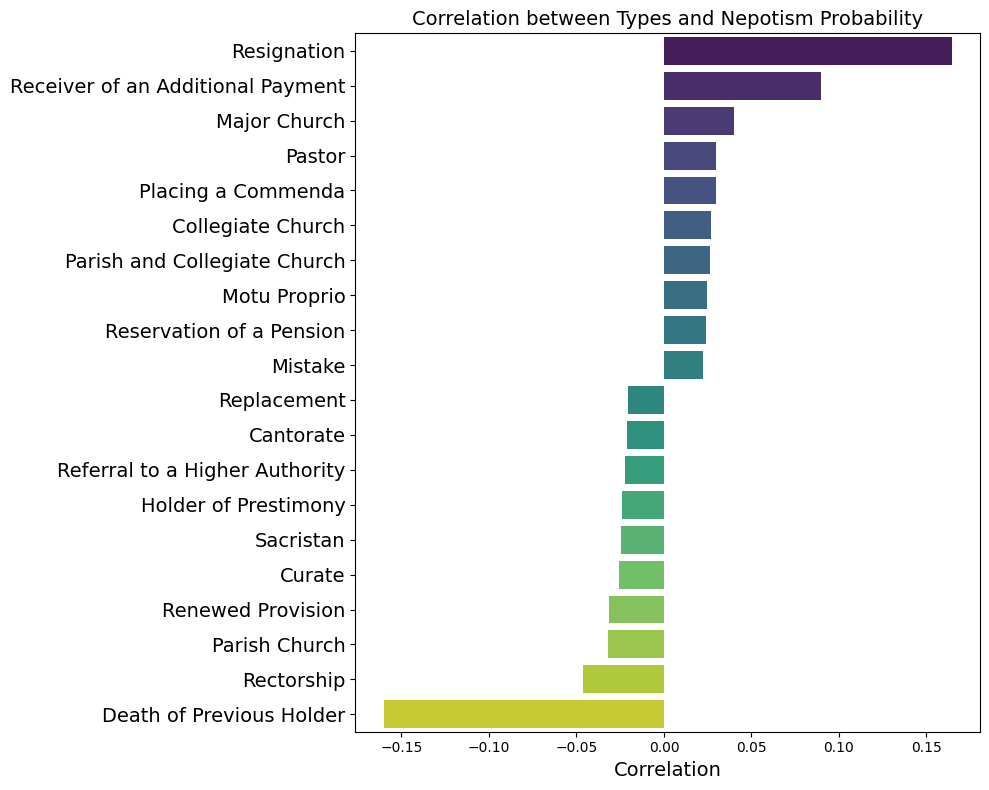

In [29]:
top_bottom_df.reset_index(inplace=True)
top_bottom_df.rename(columns={'index': 'Type_Label'}, inplace=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Correlation',
    y='Type_Label',
    data=top_bottom_df,
    hue='Type_Label',
    palette='viridis',
    legend=False
)
plt.title('Correlation between Types and Nepotism Probability', fontsize=14)
plt.xlabel('Correlation', fontsize=14)
plt.ylabel(None)

ax = plt.gca()
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
ax.set_yticklabels([titlecase(label.get_text()) for label in ax.get_yticklabels()], fontsize=14)

plt.tight_layout()
plt.savefig(output_path_render + "Nepotism_Correlations.png", dpi=300, format='png')
plt.show()

In [30]:
import statsmodels.api as sm

X = type_dummies
y = final_results[dep_var]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         combined_score   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.771
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           5.94e-47
Time:                        12:45:57   Log-Likelihood:                 2500.5
No. Observations:                7097   AIC:                            -4699.
Df Residuals:                    6946   BIC:                            -3662.
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

### Date vs. Combined Score

In [31]:
df_t = final_results.copy()
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7097 entries, 1568 to 3548
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event_id           7097 non-null   object 
 1   person1_id         7097 non-null   object 
 2   person2_id         7097 non-null   object 
 3   person1_span_text  7097 non-null   object 
 4   person2_span_text  7097 non-null   object 
 5   extracted_name1    7097 non-null   object 
 6   extracted_name2    7097 non-null   object 
 7   person1_role       7097 non-null   object 
 8   person2_role       7097 non-null   object 
 9   ratio_score        7097 non-null   float64
 10  diocese_id         7097 non-null   object 
 11  diocese_name       7097 non-null   object 
 12  type_labels        7097 non-null   object 
 13  date               6321 non-null   object 
 14  confidence         7097 non-null   float64
 15  combined_score     7097 non-null   float64
 16  name_frequency     7097 no

In [32]:
df_t = df_t.dropna(subset=['date'])

In [33]:
df_t["month"] = df_t["date"].apply(lambda d: d.strftime("%B") if d else None)
df_t["date_ordinal"] = df_t["date"].apply(lambda d: d.toordinal())
df_t[dep_var] = pd.to_numeric(df_t[dep_var], errors='coerce')
df_t = df_t.dropna(subset=[dep_var, 'date_ordinal'])

In [34]:
correlation, p_val = pearsonr(df_t["date_ordinal"], df_t[dep_var])
print(f"Correlation between 'combined_score' and 'date': {correlation}, {p_val}")

Correlation between 'combined_score' and 'date': 0.06723484242039161, 8.771894783539651e-08


In [35]:
grouped_data = df_t.groupby("month")[dep_var]
for month, scores in grouped_data:
    w, p = shapiro(scores)
    print(f"Shapiro test for {month}: W={w:.4f}, p={p:.4f}")


anova_groups = [scores for _, scores in grouped_data]
f_val, p_val = f_oneway(*anova_groups)
print(f"ANOVA: F={f_val:.4f}, p={p_val:.4f}")

Shapiro test for April: W=0.2725, p=0.0000
Shapiro test for August: W=0.3213, p=0.0000
Shapiro test for December: W=0.3015, p=0.0000
Shapiro test for February: W=0.3478, p=0.0000
Shapiro test for January: W=0.2844, p=0.0000
Shapiro test for July: W=0.4473, p=0.0000
Shapiro test for June: W=0.4007, p=0.0000
Shapiro test for March: W=0.1927, p=0.0000
Shapiro test for May: W=0.2192, p=0.0000
Shapiro test for November: W=0.2579, p=0.0000
Shapiro test for October: W=0.3574, p=0.0000
Shapiro test for September: W=0.3186, p=0.0000
ANOVA: F=4.3616, p=0.0000


In [36]:
data_month = pd.get_dummies(df_t, columns=["month"], drop_first=True)
dummy_cols = [col for col in data_month.columns if col.startswith("month_")]

In [37]:
correlations = {}
for col in dummy_cols:
    correlation, p_val = pearsonr(data_month[col], data_month[dep_var])
    correlations[col] = {'Correlation': correlation, 'P-Value': p_val}

import pandas as pd
corr_df = pd.DataFrame.from_dict(correlations, orient='index')
corr_df = corr_df.sort_values("Correlation", ascending=False)
print(corr_df)

                 Correlation   P-Value
month_July          0.054934  0.000012
month_October       0.029568  0.018730
month_June          0.028517  0.023377
month_September     0.002353  0.851607
month_December      0.000363  0.976949
month_February     -0.000026  0.998359
month_August       -0.006575  0.601203
month_January      -0.017405  0.166472
month_November     -0.022076  0.079250
month_May          -0.027741  0.027418
month_March        -0.034290  0.006402


In [38]:
# Define dependent and independent variables
data_month[dummy_cols] = data_month[dummy_cols].astype(int)
X = data_month[dummy_cols] # data_month.select_dtypes(include=[np.number]).drop(columns=[dep_var], errors="ignore")
y = data_month[dep_var]  # Dependent variable

X = sm.add_constant(X)  # Add constant term
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         combined_score   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.362
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.53e-06
Time:                        12:45:57   Log-Likelihood:                 1918.7
No. Observations:                6321   AIC:                            -3813.
Df Residuals:                    6309   BIC:                            -3732.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0345      0.009     

## Filter (Optional)

In [39]:
final_filtered_filtered = final_results[final_results['combined_score'] >= 0.4]
final_filtered_filtered = final_filtered_filtered.sort_values(by='combined_score', ascending=False)
final_filtered_filtered.to_csv(output_path_data + "nepotism_filtered.csv")
print(len(final_filtered_filtered))

557


In [40]:
final_filtered_filtered.head(10)

,event_id,person1_id,person2_id,person1_span_text,person2_span_text,extracted_name1,extracted_name2,person1_role,person2_role,ratio_score,diocese_id,diocese_name,type_labels,date,confidence,combined_score,name_frequency,likelihood
1568,https://g17.dhi-roma.it/resources/event_8798,,,Mathurini etiam Dupin,Ludovicus Dupin,Dupin,Dupin,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_50,Andegavensis,"apostolic provision,papal grace",1677-12-12,1.0,1.0,95,significant
638,https://g17.dhi-roma.it/resources/event_1860,,,Caroli etiam Gorra,Vespasianus Gorra,Gorra,Gorra,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_460,Placentina provinciae Bononiensis,"Resignation,apostolic provision,papal grace,Ab...",1678-09-30,1.0,1.0,151,significant
5244,https://g17.dhi-roma.it/resources/event_8454,,,Renatus Beauxamis,Petri etiam Beauxamis,Beauxamis,Beauxamis,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_50,Andegavensis,"apostolic provision,papal grace,death of previ...",1677-11-07,1.0,1.0,16,significant
918,https://g17.dhi-roma.it/resources/event_9065,,,Ludovicus Dupin,Mathurini etiam Dupin,Dupin,Dupin,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_50,Andegavensis,"apostolic provision,papal grace",1677-12-26,1.0,1.0,95,significant
6519,https://g17.dhi-roma.it/resources/event_2657,,,Francisci etiam Garnier,Joannes Garnier,Garnier,Garnier,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_589,Turonensis,"Placing a commenda,apostolic provision,papal g...",1678-07-08,1.0,1.0,241,significant
3978,https://g17.dhi-roma.it/resources/event_153,,,Alexius Oliverii,Jois Baptistae etiam Oliverii,Oliverii,Oliverii,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_423,Nucerina,"Resignation,apostolic provision,papal grace,Ho...",1678-09-02,1.0,1.0,107,significant
2071,https://g17.dhi-roma.it/resources/event_8638,,,Ludovici etiam Geuffrin,Simon Petrus Geuffrin,Geuffrin,Geuffrin,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_709,Noviomensis,"apostolic provision,papal grace,Without care o...",1677-12-02,1.0,1.0,27,significant
632,https://g17.dhi-roma.it/resources/event_8330,,,Guillelmus Botherhou,Iois etiam Botherhou,Botherhou,Botherhou,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_111,Bisuntina,"apostolic provision,papal grace,Pastor,church,...",1622-02-16,1.0,1.0,23,significant
4013,https://g17.dhi-roma.it/resources/event_9331,,,Francisci etiam Rimbaud,Petrus Rimbaud,Rimbaud,Rimbaud,former possessor,providee,1.0,https://g17.dhi-roma.it/resources/institution_404,Narbonensis,"apostolic provision,papal grace,Without care o...",1678-01-15,1.0,1.0,65,significant
5954,https://g17.dhi-roma.it/resources/event_8155,,,Guillelmus Bontherhoux,Iois etiam Bontherhoux,Bontherhoux,Bontherhoux,providee,former possessor,1.0,https://g17.dhi-roma.it/resources/institution_111,Bisuntina,"apostolic provision,papal grace,Canonship and ...",1622-02-16,1.0,1.0,20,significant


## Aggregate

In [41]:
# Aggregation for each diocese
aggregated_diocese = final_results.groupby(["diocese_id", "diocese_name"]).agg(
    average_combined_score=("combined_score", "mean"),
    average_ratio_score=("ratio_score", "mean"),
    count_positive_score=("combined_score", lambda x: (x > 0).sum()),
    total_events=("event_id", "count"),
    unique_persons=("person1_id", lambda x: x.nunique() + final_results.loc[final_results["diocese_id"] == x.name[0], "person2_id"].nunique())
).reset_index()

# Sorting according to the average combined_score
aggregated_diocese = aggregated_diocese.sort_values(by="average_combined_score", ascending=False)

In [42]:
#@title Filter by event count
if event_count_threshold_nepotism>0:
  aggregated_diocese = aggregated_diocese[aggregated_diocese['total_events'] >= event_count_threshold_nepotism]

### Data Checks and Insights

In [43]:
# Output results
aggregated_diocese.head(10)

,diocese_id,diocese_name,average_combined_score,average_ratio_score,count_positive_score,total_events,unique_persons
494,https://g17.dhi-roma.it/resources/institution_68,Arelatensis,0.500000,0.600000,3,5,1
118,https://g17.dhi-roma.it/resources/institution_176,Cauriensis,0.356667,0.390000,6,15,1
310,https://g17.dhi-roma.it/resources/institution_423,Nucerina,0.344800,0.377600,10,25,1
388,https://g17.dhi-roma.it/resources/institution_517,Sancti Papuli,0.300000,0.400000,2,5,1
377,https://g17.dhi-roma.it/resources/institution_501,Sagiensis,0.250000,0.375000,3,8,1
134,https://g17.dhi-roma.it/resources/institution_197,Clusinensis,0.250000,0.250000,3,12,1
193,https://g17.dhi-roma.it/resources/institution_273,Gallipolitana,0.250000,0.250000,2,6,1
254,https://g17.dhi-roma.it/resources/institution_356,Marianensis,0.240000,0.240000,2,8,1
272,https://g17.dhi-roma.it/resources/institution_379,Miletensis,0.239444,0.276667,3,9,1
336,https://g17.dhi-roma.it/resources/institution_456,Pientina,0.216250,0.432500,6,12,1


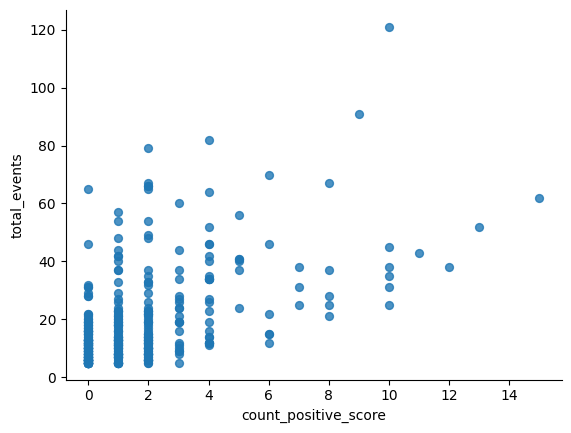

In [44]:
from matplotlib import pyplot as plt
aggregated_diocese.plot(kind='scatter', x='count_positive_score', y='total_events', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

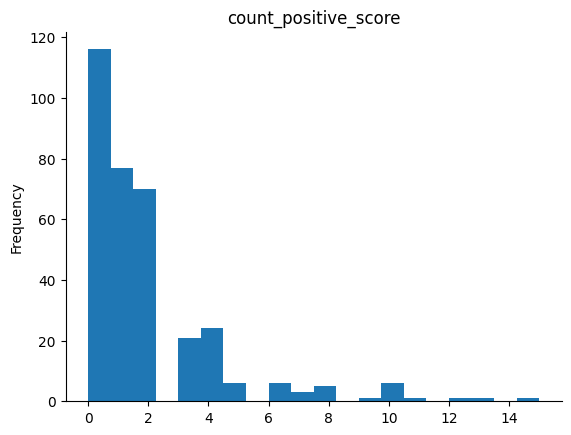

In [45]:
from matplotlib import pyplot as plt
aggregated_diocese['count_positive_score'].plot(kind='hist', bins=20, title='count_positive_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

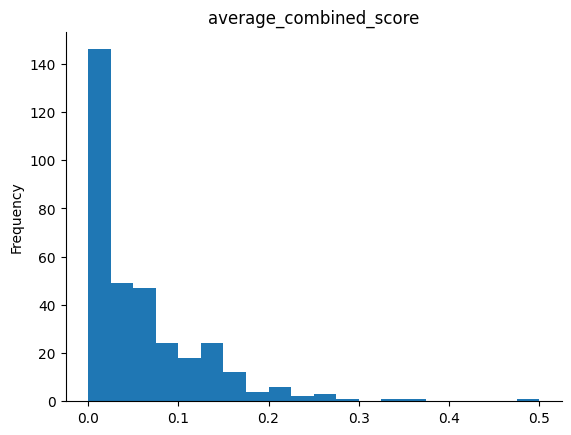

In [46]:
from matplotlib import pyplot as plt
aggregated_diocese['average_combined_score'].plot(kind='hist', bins=20, title='average_combined_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [47]:
# Calculate mean and standard deviation
mean_ratio = aggregated_diocese["average_combined_score"].mean()
std_dev_ratio = aggregated_diocese["average_combined_score"].std()

# Define thresholds
low_threshold = mean_ratio - std_dev_ratio
high_threshold = mean_ratio + std_dev_ratio
significant_threshold = mean_ratio + 2 * std_dev_ratio

# Analyze each event
aggregated_diocese["likelihood"] = aggregated_diocese["average_combined_score"].apply(
    lambda x: "significant" if x >= significant_threshold else
              "high" if x >= high_threshold else
              "low" if x <= low_threshold else
              "typical"
)

print("Mean Ratio:", mean_ratio)
print("Standard Deviation:", std_dev_ratio)
aggregated_diocese.sort_values(by='average_combined_score', ascending=False, inplace=True)
aggregated_diocese.to_csv(output_path_data + "dioceses_nepotism_aggregated.csv")
aggregated_diocese.head(1100)

Mean Ratio: 0.05618224786829477
Standard Deviation: 0.06878504327730872


,diocese_id,diocese_name,average_combined_score,average_ratio_score,count_positive_score,total_events,unique_persons,likelihood
494,https://g17.dhi-roma.it/resources/institution_68,Arelatensis,0.500000,0.6000,3,5,1,significant
118,https://g17.dhi-roma.it/resources/institution_176,Cauriensis,0.356667,0.3900,6,15,1,significant
310,https://g17.dhi-roma.it/resources/institution_423,Nucerina,0.344800,0.3776,10,25,1,significant
388,https://g17.dhi-roma.it/resources/institution_517,Sancti Papuli,0.300000,0.4000,2,5,1,significant
377,https://g17.dhi-roma.it/resources/institution_501,Sagiensis,0.250000,0.3750,3,8,1,significant
...,...,...,...,...,...,...,...,...
530,https://g17.dhi-roma.it/resources/institution_77,Astensis,0.000000,0.0000,0,7,2,typical
532,https://g17.dhi-roma.it/resources/institution_79,Atrebatensis,0.000000,0.0000,0,8,1,typical
537,https://g17.dhi-roma.it/resources/institution_90,Auxitana,0.000000,0.0000,0,17,1,typical
542,https://g17.dhi-roma.it/resources/institution_94,Baiocensis,0.000000,0.0000,0,22,1,typical


# Lead Speed

## Fetch Data

In [48]:
event_data_raw_lead = pd.DataFrame

### SPARQL

alternative statements for type container


```sparql
  {
    ?event grace:type_object ?midEntity .
  }
  UNION
  {
    ?event grace:object_object ?b .
    ?b grace:type_object ?midEntity .
  }
  UNION
  {
    ?event grace:object_object+ ?b .
    ?b a grace:benefice ;
       grace:type_object ?midEntity .
  }
  ?midEntity (grace:broader*) ?entity .
```



In [49]:
# @title Extensive Query
events_query =  """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX grace: <https://g17.dhi-roma.it/ontology/>
PREFIX g17raw: <https://g17.dhi-roma.it/raw/>
PREFIX g17: <https://g17.dhi-roma.it/resources/>

SELECT ?event ?event_label ?date_value_7 ?date_value_4 ?diocese_11 ?diocese_11_label
  ?province ?province_label ?map_15 ?place_13 ?place_13_label ?place_17 ?place_17_label
  ?map_19 (GROUP_CONCAT(DISTINCT ?type_label; SEPARATOR = ",") AS ?type_labels)
WHERE {
  ?event rdf:type grace:event ;
           grace:called ?event_label ;
           grace:event_date ?date_2 ;
           grace:vacancy_date ?date_5 ;
           grace:place_of_event ?place_17 ;
           grace:testified_by ?ENTRY_2 .
  ?ENTRY_2 rdf:type grace:entry ;
           grace:in_source ?SOURCE_4 .
  VALUES ?SOURCE_4 { g17:source_1 g17:source_2 }
  ?date_2 rdf:type grace:date ;
          grace:mid_date ?date_value_4 .
  ?date_5 rdf:type grace:date ;
          grace:mid_date ?date_value_7 .
  ?event (grace:object_object|^grace:event_object)*/grace:in_diocese ?diocese_11 .
  ?diocese_11 rdf:type grace:diocese ;
              grace:called ?diocese_11_label ;
              grace:under_jurisdiction ?province ;
              grace:primary_place ?place_13 .
  ?province rdf:type grace:ecclesiastical_province ;
            grace:called ?province_label .
  ?place_13 rdf:type grace:place ;
            grace:called ?place_13_label ;
            grace:wkt ?map_15 .
  ?place_17 rdf:type grace:place ;
            grace:called ?place_17_label ;
            grace:wkt ?map_19 .
  ?event ((grace:type_object|(grace:object_object|^grace:object_related_to_event)+/grace:type_object)/grace:broader*) ?entity .

#  ?event ((grace:type_object|(grace:object_related_to_object_directed)+/grace:type_object)/grace:broader*) ?entity .

  ?entity a grace:term .
  FILTER(NOT EXISTS { ?entity grace:in_thesaurus ?thesaurus.
      VALUES ?thesaurus {
        g17:type_459 # type of object
        # g17:type_142 # subtype of event
        g17:type_50 # exclude types of subregister
      }. })
  ?entity grace:called ?type_label .
}
GROUP BY ?event ?event_label ?date_value_7 ?date_value_4 ?diocese_11 ?diocese_11_label
  ?province ?province_label ?map_15 ?place_13 ?place_13_label ?place_17 ?place_17_label
  ?map_19
"""
try:
  event_data_raw_lead = fetch_data_from_sparql(endpoint_url, events_query)
  print(len(event_data_raw_lead))
except Exception as e:
  print(e)

3227


### CSV

In [50]:
if event_data_raw_lead.empty:
  event_data_raw_lead = pd.read_csv(input_path_data + 'Lead-Speed.csv')

### Data Checks

In [51]:
print(len(event_data_raw_lead))

3227


In [52]:
df = event_data_raw_lead.copy()

In [53]:
df.head(5)

,event,event_label,date_value_7,date_value_4,diocese_11,diocese_11_label,province,province_label,map_15,place_13,place_13_label,place_17,place_17_label,map_19,type_labels
0,https://g17.dhi-roma.it/resources/event_7157,APOSTOLIC PROVISION 7157,1678-05-16,1678-08-13,https://g17.dhi-roma.it/resources/institution_183,Cerviensis,https://g17.dhi-roma.it/resources/institution_891,Bologna,POINT (12.366666666667 44.25),https://g17.dhi-roma.it/resources/place_177,Cervia,https://g17.dhi-roma.it/resources/place_656,Basilica di Santa Maria Maggiore,POINT (12.498611111111 41.8975),"apostolic provision,papal grace,death of previ..."
1,https://g17.dhi-roma.it/resources/event_3691,APOSTOLIC PROVISION 3691,1676-04-07,1678-07-07,https://g17.dhi-roma.it/resources/institution_223,Cremonensis,https://g17.dhi-roma.it/resources/institution_838,Milano,POINT (10.024722222222222 45.13333333333333),https://g17.dhi-roma.it/resources/place_216,Cremona,https://g17.dhi-roma.it/resources/place_656,Basilica di Santa Maria Maggiore,POINT (12.498611111111 41.8975),"apostolic provision,papal grace,Referral to a ..."
2,https://g17.dhi-roma.it/resources/event_5482,APOSTOLIC PROVISION 5482,1621-07-16,1622-04-08,https://g17.dhi-roma.it/resources/institution_608,Vallisolitana,https://g17.dhi-roma.it/resources/institution_871,Toledo,POINT (-4.7285611111111 41.651980555556),https://g17.dhi-roma.it/resources/place_592,Valladolid,https://g17.dhi-roma.it/resources/place_649,Rome,POINT (12.482777777778 41.893055555556),"apostolic provision,papal grace,death of previ..."
3,https://g17.dhi-roma.it/resources/event_6044,APOSTOLIC PROVISION 6044,1622-05-16,1622-07-18,https://g17.dhi-roma.it/resources/institution_275,Gandavensis,https://g17.dhi-roma.it/resources/institution_...,Mechelen-Bruxelles,POINT (3.725277777777778 51.05361111111111),https://g17.dhi-roma.it/resources/place_266,Ghent,https://g17.dhi-roma.it/resources/place_656,Basilica di Santa Maria Maggiore,POINT (12.498611111111 41.8975),"apostolic provision,papal grace,death of previ..."
4,https://g17.dhi-roma.it/resources/event_4466,APOSTOLIC PROVISION 4466,1622-10-16,1623-01-13,https://g17.dhi-roma.it/resources/institution_566,Tirasonensis,https://g17.dhi-roma.it/resources/institution_869,Zaragoza,POINT (-1.7225 41.904444444444),https://g17.dhi-roma.it/resources/place_553,Tarazona,https://g17.dhi-roma.it/resources/place_649,Rome,POINT (12.482777777778 41.893055555556),"apostolic provision,papal grace,death of previ..."


## Parsing

### Date Parsing

In [54]:
print(df[['date_value_7', 'date_value_4']])

     date_value_7 date_value_4
0      1678-05-16   1678-08-13
1      1676-04-07   1678-07-07
2      1621-07-16   1622-04-08
3      1622-05-16   1622-07-18
4      1622-10-16   1623-01-13
...           ...          ...
3222   1622-07-16   1622-09-01
3223   1622-08-16   1622-10-02
3224   1678-04-15   1678-07-30
3225   1672-02-15   1677-11-13
3226   1622-08-16   1623-02-13

[3227 rows x 2 columns]


In [55]:
def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%Y-%m-%d').date()
    except (ValueError, TypeError):
        return None
df['date_value_7'] = df['date_value_7'].apply(parse_date)
df['date_value_4'] = df['date_value_4'].apply(parse_date)

In [56]:
print(df[['date_value_7', 'date_value_4']])

     date_value_7 date_value_4
0      1678-05-16   1678-08-13
1      1676-04-07   1678-07-07
2      1621-07-16   1622-04-08
3      1622-05-16   1622-07-18
4      1622-10-16   1623-01-13
...           ...          ...
3222   1622-07-16   1622-09-01
3223   1622-08-16   1622-10-02
3224   1678-04-15   1678-07-30
3225   1672-02-15   1677-11-13
3226   1622-08-16   1623-02-13

[3227 rows x 2 columns]


In [57]:
df['time_delta'] = df.apply(
    lambda row: (row['date_value_4'] - row['date_value_7']).days if row['date_value_4'] and row['date_value_7'] else None,
    axis=1
)
df['time_delta'] = df['time_delta'].apply(lambda x: 0.4 if x == 0 else x)
df = df.dropna(subset=['time_delta'])


In [58]:
print(df[['date_value_7', 'date_value_4']])


     date_value_7 date_value_4
0      1678-05-16   1678-08-13
1      1676-04-07   1678-07-07
2      1621-07-16   1622-04-08
3      1622-05-16   1622-07-18
4      1622-10-16   1623-01-13
...           ...          ...
3222   1622-07-16   1622-09-01
3223   1622-08-16   1622-10-02
3224   1678-04-15   1678-07-30
3225   1672-02-15   1677-11-13
3226   1622-08-16   1623-02-13

[3219 rows x 2 columns]


### GIS Parsing

In [59]:
df = df.dropna(subset=['map_15', 'map_19'])
df = df[df['map_15'].str.startswith('POINT', na=False)]
df = df[df['map_19'].str.startswith('POINT', na=False)]
df['geometry_15'] = df['map_15'].apply(wkt.loads)
df['geometry_19'] = df['map_19'].apply(wkt.loads)
df['coords_15'] = df['geometry_15'].apply(lambda point: (point.y, point.x))
df['coords_19'] = df['geometry_19'].apply(lambda point: (point.y, point.x))
df['distance'] = df.apply(
    lambda row: geodesic(row['coords_15'], row['coords_19']).kilometers, axis=1
)
df = df[df['distance'] > 0]
df.to_csv(output_path_data + "lead_speed.csv")

### Filter thresholds

In [60]:
df_t = df.copy()

In [61]:
if distance_threshold>0:
  df_t = df[df['distance'] < distance_threshold]

if time_delta_threshold>0:
  df_t = df[df['time_delta'] < time_delta_threshold]

In [62]:
df_t.to_csv(output_path_data + "lead_speed_filtered.csv")

## Saisonality Check

In [63]:
df_season = df_t.copy()

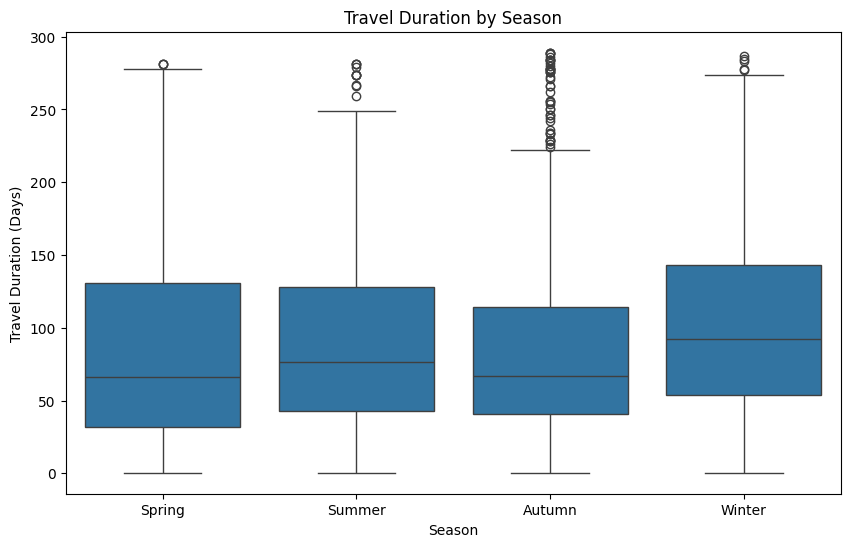

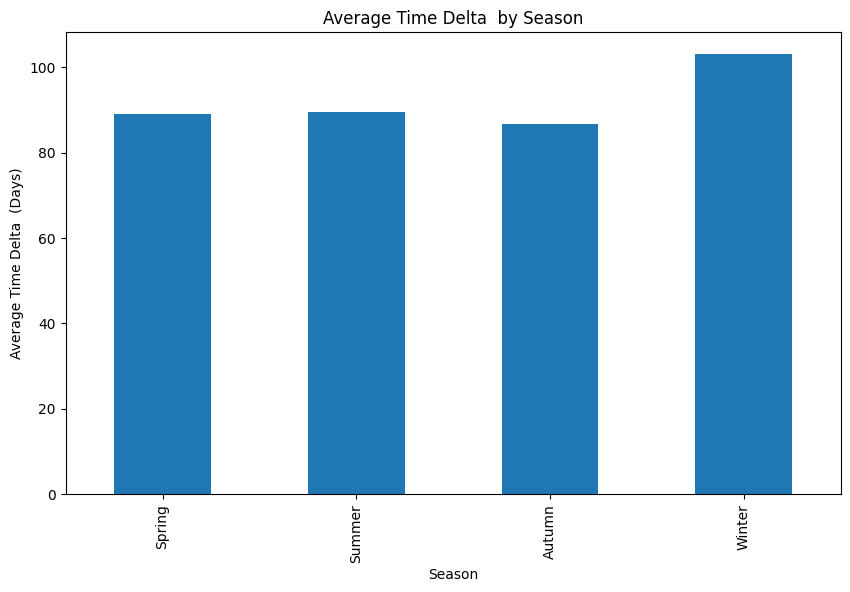

In [64]:
# Function to determine the season based on the month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:  # December, January, February -> Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # March, April, May -> Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # June, July, August -> Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # September, October, November -> Autumn
        return 'Autumn'

# Add a new column "season" based on the date
df_season['season'] = df_season['date_value_7'].apply(get_season)

# Boxplot: Distribution of travel duration (time_delta) by season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='time_delta', data=df_season, order=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.title('Travel Duration by Season')
plt.xlabel('Season')
plt.ylabel('Travel Duration (Days)')
plt.show()

# Calculate the average travel duration per season
avg_duration = df_season.groupby('season')['time_delta'].mean().reindex(['Spring', 'Summer', 'Autumn', 'Winter'])

# Bar plot: Average travel duration per season
plt.figure(figsize=(10, 6))
avg_duration.plot(kind='bar')
plt.title('Average Time Delta  by Season')
plt.xlabel('Season')
plt.ylabel('Average Time Delta  (Days)')
plt.show()


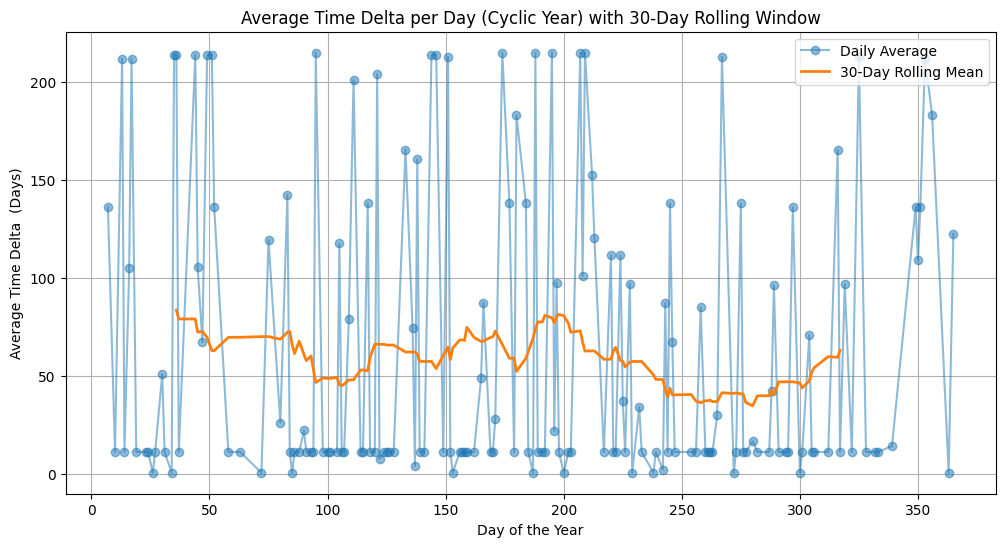

In [65]:
# Extract the day of the year from the date column
df_season['day_of_year'] = df_season['date_value_7'].apply(lambda d: d.timetuple().tm_yday)

# Compute the daily average travel duration across all years
daily_avg = df_season.groupby('day_of_year')['time_delta'].mean()

# Compute the 30-day rolling average
rolling_avg = daily_avg.rolling(window=30, center=True).mean()

# Plot daily average and rolling average
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', alpha=0.5, label='Daily Average')
plt.plot(rolling_avg.index, rolling_avg.values, linestyle='-', linewidth=2, label='30-Day Rolling Mean')
plt.title('Average Time Delta per Day (Cyclic Year) with 30-Day Rolling Window')
plt.xlabel('Day of the Year')
plt.ylabel('Average Time Delta  (Days)')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
corr, p_value = pearsonr(df_season['day_of_year'], df_season['time_delta'])
print("Pearson correlation:", corr)
print("p-Wert:", p_value)

Pearson correlation: -0.04328568828813966
p-Wert: 0.023513294411516245


In [67]:
df_season.columns

Index(['event', 'event_label', 'date_value_7', 'date_value_4', 'diocese_11',
       'diocese_11_label', 'province', 'province_label', 'map_15', 'place_13',
       'place_13_label', 'place_17', 'place_17_label', 'map_19', 'type_labels',
       'time_delta', 'geometry_15', 'geometry_19', 'coords_15', 'coords_19',
       'distance', 'season', 'day_of_year'],
      dtype='object')

January: Pearson Correlation = 0.039, p-value = 0.039
February: Pearson Correlation = 0.052, p-value = 0.006
March: Pearson Correlation = 0.031, p-value = 0.105
April: Pearson Correlation = 0.044, p-value = 0.020
May: Pearson Correlation = -0.067, p-value = 0.000
June: Pearson Correlation = -0.083, p-value = 0.000
July: Pearson Correlation = 0.001, p-value = 0.958
August: Pearson Correlation = 0.026, p-value = 0.169
September: Pearson Correlation = -0.068, p-value = 0.000
October: Pearson Correlation = -0.069, p-value = 0.000
November: Pearson Correlation = -0.006, p-value = 0.756
December: Pearson Correlation = 0.106, p-value = 0.000


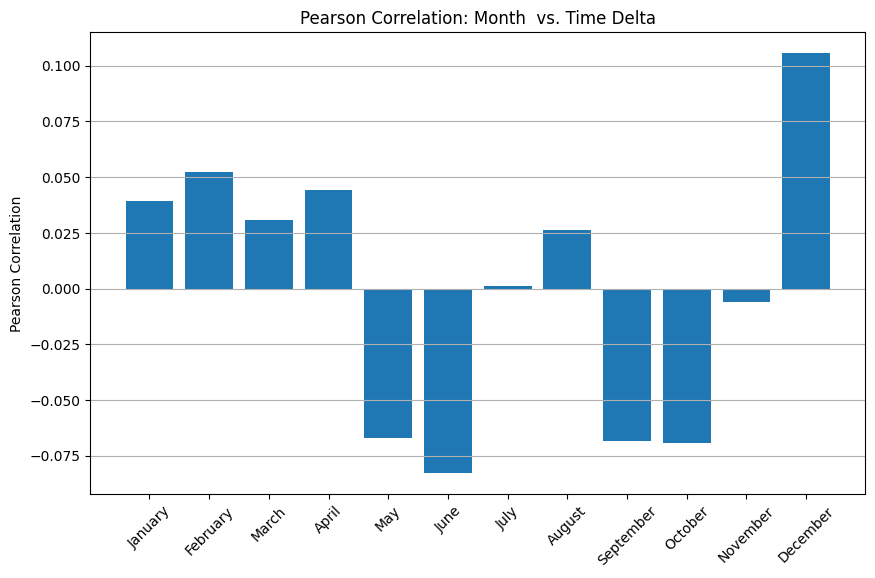

In [68]:
# Extract month as an integer (1-12)
df_season['month_num'] = df_season['date_value_4'].apply(lambda d: d.month)

# Map month number to English month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
df_season['month_name'] = df_season['month_num'].map(month_names)

# Create dummy variables for the month names
month_dummies = pd.get_dummies(df_season['month_name'])
df_season = df_season.drop(columns=month_dummies.columns, errors='ignore')
df_season = pd.concat([df_season, month_dummies], axis=1)

# Calculate Pearson correlation between each month dummy and 'time_delta'
correlations = {}
p_values = {}
for month in month_names.values():
    dummy_col = f'{month}'
    if dummy_col in df_season.columns:
        corr, p_val = pearsonr(df_season[dummy_col], df_season['time_delta'])
        correlations[dummy_col] = corr
        p_values[dummy_col] = p_val
        print(f'{month}: Pearson Correlation = {corr:.3f}, p-value = {p_val:.3f}')

# Optional visualization: Bar plot of the correlation coefficients
plt.figure(figsize=(10, 6))
plt.bar(correlations.keys(), correlations.values())
plt.title('Pearson Correlation: Month  vs. Time Delta')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [69]:
if normalize_seasonality:
  overall_mean = df_season['time_delta'].mean()
  df_season['seasonal_mean'] = df_season.groupby('season')['time_delta'].transform('mean')
  df_season['time_delta_normalized'] = df_season['time_delta'] * (overall_mean / df_season['seasonal_mean'])
  # df_t['time_delta'] = df_season['time_delta'] - df_season.groupby('season')['time_delta'].transform('mean')
  df_t['time_delta'] = df_season['time_delta_normalized']

## Calculation

In [70]:
if distance_log:
  df_t['event_lead_speed'] = np.log(df_t['distance']) / df_t['time_delta']
else:
  df_t['event_lead_speed'] = df_t['distance'] / df_t['time_delta']

df_sorted = df_t.sort_values(by='event_lead_speed', ascending=False)
df_sorted.to_csv(output_path_data + "lead_speed.csv")
print(len(df_sorted))

2738


C:\Users\c.sander\AppData\Local\Temp\ipykernel_30604\3357831632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['event_lead_speed'] = df_t['distance'] / df_t['time_delta']


## Aggregation

### Dioceses

In [ ]:
diocese_group = df_t.groupby(['diocese_11', 'diocese_11_label'])

diocese_stats = diocese_group.agg({
    'event_lead_speed': speed_diocese_lead_speed_agg,
    'time_delta': time_diocese_lead_speed_agg,
    'distance': 'mean'
}).reset_index()

diocese_stats['distance_sum'] = diocese_group['distance'].sum().values
diocese_stats['time_delta_sum'] = diocese_group['time_delta'].sum().values

diocese_stats['event_count'] = diocese_group.size().values
diocese_stats['time_delta'] = diocese_stats['time_delta'].apply(lambda x: 0.4 if x == 0 else x)
diocese_stats = diocese_stats[
   (diocese_stats['distance'] > 0)
]
if distance_log:
    diocese_stats['diocese_lead_speed'] = np.log(diocese_stats['distance']) / diocese_stats['time_delta']
else:
    # diocese_stats = diocese_stats.rename(columns={'event_lead_speed': 'diocese_lead_speed'})
    diocese_stats['diocese_lead_speed'] = diocese_stats['distance_sum'] / diocese_stats['time_delta_sum']

diocese_stats_sorted = diocese_stats.sort_values(by='diocese_lead_speed', ascending=False)
diocese_stats_sorted.to_csv(output_path_data + 'diocese_lead_speed.csv')
print(len(diocese_stats_sorted))

362


In [238]:
diocese_geoms = df_t[['diocese_11', 'diocese_11_label', 'geometry_15']].drop_duplicates()
diocese_stats = diocese_stats.merge(diocese_geoms, on=['diocese_11', 'diocese_11_label'])
gdf_events = gpd.GeoDataFrame(df_t, geometry='geometry_19', crs='EPSG:4326')
gdf_diocese = gpd.GeoDataFrame(diocese_stats, geometry='geometry_15', crs='EPSG:4326')

In [239]:
gdf_diocese.to_file(output_path_data + 'gdf_diocese.geojson', driver='GeoJSON')
gdf_events.to_file(output_path_data + 'gdf_events.geojson', driver='GeoJSON')

INFO:pyogrio._io:Created 362 records
INFO:pyogrio._io:Created 2,738 records


In [240]:
#@title Filter Aggregation
if event_count_threshold_lead_speed>0:
  gdf_diocese = gdf_diocese[gdf_diocese['event_count'] >= event_count_threshold_lead_speed]

## Correlations

### Find Ideal Threshold

In [123]:
# Create a copy of the original DataFrame
df_threshold = df.copy()

# Calculate basic statistics for the 'time_delta' column
mean_time_delta = df_threshold['time_delta'].mean()       # Mean
median_time_delta = df_threshold['time_delta'].median()   # Median
std_time_delta = df_threshold['time_delta'].std()         # Standard deviation

# Print mean, median, and standard deviation
print(f"mean time_delta: {mean_time_delta}")
print(f"median  time_delta: {median_time_delta}")
print(f"Standardabweichung von time_delta: {std_time_delta}")

# Calculate quartiles and interquartile range (IQR)
q1 = df_threshold['time_delta'].quantile(0.25)  # First quartile (25%)
median = df_threshold['time_delta'].median()    # Median (50%)
q3 = df_threshold['time_delta'].quantile(0.75)  # Third quartile (75%)
iqr = q3 - q1                                    # Interquartile range

# Print quartile statistics and IQR
print(f"1. Quartil (25%): {q1}")
print(f"Median (50%): {median}")
print(f"3. Quartil (75%): {q3}")
print(f"Interquartilsabstand (IQR): {iqr}")

# Calculate and print skewness and kurtosis of the distribution
skewness = df_threshold['time_delta'].skew()
print(f"Schiefe von time_delta: {skewness}")

kurtosis = df_threshold['time_delta'].kurt()
print(f"Kurtosis von time_delta: {kurtosis}")

mean time_delta: 297.62785046728976
median  time_delta: 88.0
Standardabweichung von time_delta: 1092.517808683449
1. Quartil (25%): 46.0
Median (50%): 88.0
3. Quartil (75%): 182.0
Interquartilsabstand (IQR): 136.0
Schiefe von time_delta: 10.70982363585524
Kurtosis von time_delta: 145.75862119197825


In [127]:
# Without threshold
df_threshold = df.copy()

corr_no_threshold, p_val_no = pearsonr(df_threshold['distance'],(df_threshold['time_delta']))

# With Threshold
t_test= mean_time_delta #293.7040139616056 # best = 264.5483483483483
filtered_threshold_df = df_threshold[df_threshold['time_delta'] < t_test]
corr_with_threshold, p_val_with = pearsonr(filtered_threshold_df['distance'],(filtered_threshold_df['time_delta']))

print(f"Correlation without threshold: {corr_no_threshold}, {p_val_no}")
print(f"Correlation with Threshold: {corr_with_threshold}, {p_val_with}")


Correlation without threshold: 0.04027482857562039, 0.022496279885601232
Correlation with Threshold: 0.2950579014393045, 2.1835594327492813e-56


Best Threshold: 159.07787787787788
Maximum correlation: 0.3343165045344585


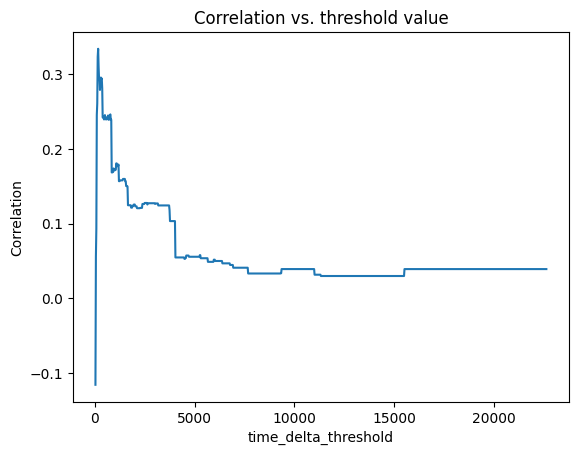

In [125]:
df_threshold = df.copy()
# Define threshold value range
time_delta_thresholds = np.linspace(df_threshold['time_delta'].min(), df_threshold['time_delta'].max(), 1000)
# time_delta_thresholds = np.linspace(df_threshold['time_delta'].min(), 1000, 95)

results = []

# Calculation of the correlation for each threshold value
for threshold in time_delta_thresholds:
    filtered_df = df_threshold[df_threshold['time_delta'] < threshold]
    if len(filtered_df) > 1:  # Ensure that at least two values are present
        corr, p_val = pearsonr((filtered_df['distance']),(filtered_df['time_delta']))
        results.append((threshold, corr))

best_threshold, max_corr = max(results, key=lambda x: x[1])

print(f"Best Threshold: {best_threshold}")
print(f"Maximum correlation: {max_corr}")

thresholds, correlations = zip(*results)
plt.plot(thresholds, correlations)
plt.title("Correlation vs. threshold value")
plt.xlabel("time_delta_threshold")
plt.ylabel("Correlation")
plt.show()


### Correlation Types vs. Lead Speed

In [ ]:
corr_mode="pearsonr"

In [ ]:
if corr_mode=="pearsonr":
    type_dummies = df_t['type_labels'].str.get_dummies(sep=',')
    df_with_dummies = pd.concat([df_t, type_dummies], axis=1)
    # Initialize a dictionary to store the correlations
    correlations = {}

    # Iterate over each category column and calculate the correlation
    for column in type_dummies.columns:
        correlation, p_val = pearsonr(df_with_dummies[column], df_with_dummies['event_lead_speed'])
        correlations[column] = {'Correlation': correlation, 'P-Value': p_val}

    # Convert the dictionary into a DataFrame for a clear presentation
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
    correlation_df = correlation_df.sort_values(by='Correlation', ascending=False).dropna()

    # Select the top and bottom 10 correlations (including p-values)
    top_bottom_df = pd.concat([correlation_df.head(10), correlation_df.tail(10)])

    # Print the result
    print(top_bottom_df)

                                  Correlation       P-Value
deceased in Rome                     0.318839  9.688974e-66
Holder of a benefice in a church     0.110754  6.226661e-09
Heir                                 0.044563  1.970635e-02
Holder of a benefice                 0.030134  1.149326e-01
Pastor                               0.027709  1.471939e-01
Placing a commenda                   0.026899  1.593950e-01
Motu proprio                         0.025893  1.755887e-01
Monastery                            0.020936  2.734648e-01
Major church                         0.019447  3.090617e-01
death of previous holder             0.019422  3.096747e-01
Holder of a portion                 -0.010192  5.939897e-01
Curate                              -0.011257  5.560154e-01
Provostship                         -0.013006  4.963400e-01
Parish hall                         -0.013042  4.951380e-01
Reservation of a pension            -0.015601  4.144992e-01
Archpriest                          -0.0

c:\Users\c.sander\AppData\Local\miniconda3\envs\Graceful17\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
if corr_mode=="pointbiserialr":
    from scipy.stats import pointbiserialr

    type_dummies = df_t['type_labels'].str.get_dummies(sep=',')
    df_with_dummies = pd.concat([df_t, type_dummies], axis=1)

    correlations = {
        col: pointbiserialr(df_with_dummies[col], df_with_dummies['event_lead_speed'])
        for col in type_dummies.columns
    }

    correlation_df = pd.DataFrame([
        {'Category': col, 'Correlation': corr[0], 'P-Value': corr[1]}
        for col, corr in correlations.items()
    ]).dropna()

    correlation_df = correlation_df.reindex(correlation_df.Correlation.abs().sort_values(ascending=False).index)
    top_bottom_df = pd.concat([correlation_df.head(10), correlation_df.tail(10)])
    print(top_bottom_df.reset_index(drop=True))


                            Category  Correlation       P-Value
0                   deceased in Rome     0.318839  9.688974e-66
1   Holder of a benefice in a church     0.110754  6.226661e-09
2                         Rectorship    -0.063932  8.163786e-04
3                      Parish Church    -0.048976  1.037409e-02
4                             church    -0.046831  1.425751e-02
5                               Heir     0.044563  1.970635e-02
6               Holder of a benefice     0.030134  1.149326e-01
7                             Pastor     0.027709  1.471939e-01
8                 Placing a commenda     0.026899  1.593950e-01
9                       Motu proprio     0.025893  1.755887e-01
10                    Hospital carer    -0.001294  9.460491e-01
11                        chancellor    -0.001233  9.485973e-01
12                            Deacon    -0.001224  9.489596e-01
13      Parish and collegiate church    -0.001146  9.522247e-01
14                 Collegiate church    

c:\Users\c.sander\AppData\Local\miniconda3\envs\Graceful17\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [ ]:
if corr_mode=="OLS":
    type_dummies = df_t['type_labels'].str.get_dummies(sep=',')
    df_with_dummies = pd.concat([df_t, type_dummies], axis=1)

    X = type_dummies
    y = df_with_dummies['event_lead_speed']

    if 'const' not in X.columns:
        X = sm.add_constant(X, has_constant='add')

    model = sm.OLS(y, X).fit()

    results_df = pd.DataFrame({
        'Coefficient': model.params,
        'P-Value': model.pvalues
    })

    results_df = results_df.drop('const', errors='ignore').sort_values(by='Coefficient', key=abs, ascending=False)
    top_bottom_df = pd.concat([results_df.head(10), results_df.tail(10)])
    print(top_bottom_df)

                                  Coefficient       P-Value
Deacon                            -222.204966  1.831722e-01
deceased in Rome                   204.826058  4.771824e-63
chancellor                        -197.460749  2.363094e-01
Hospital carer                    -115.338408  4.903428e-01
Basilica                          -115.304381  1.027030e-01
Motu proprio                      -103.657694  3.861105e-02
Reservation of a pension            98.749099  4.494070e-02
Holder of a benefice in a church    97.319639  6.519089e-09
Holder of a clerical benefice      -93.847158  2.495362e-03
death of previous holder            93.508918  4.874971e-02
Church in a priory                  -2.898908  9.861298e-01
Minor church                         2.895010  9.764832e-01
Guard                               -2.739986  9.868629e-01
Lector                              -2.736984  9.709338e-01
Restoration                          2.685602  9.453682e-01
Becoming a surrogate                 1.9

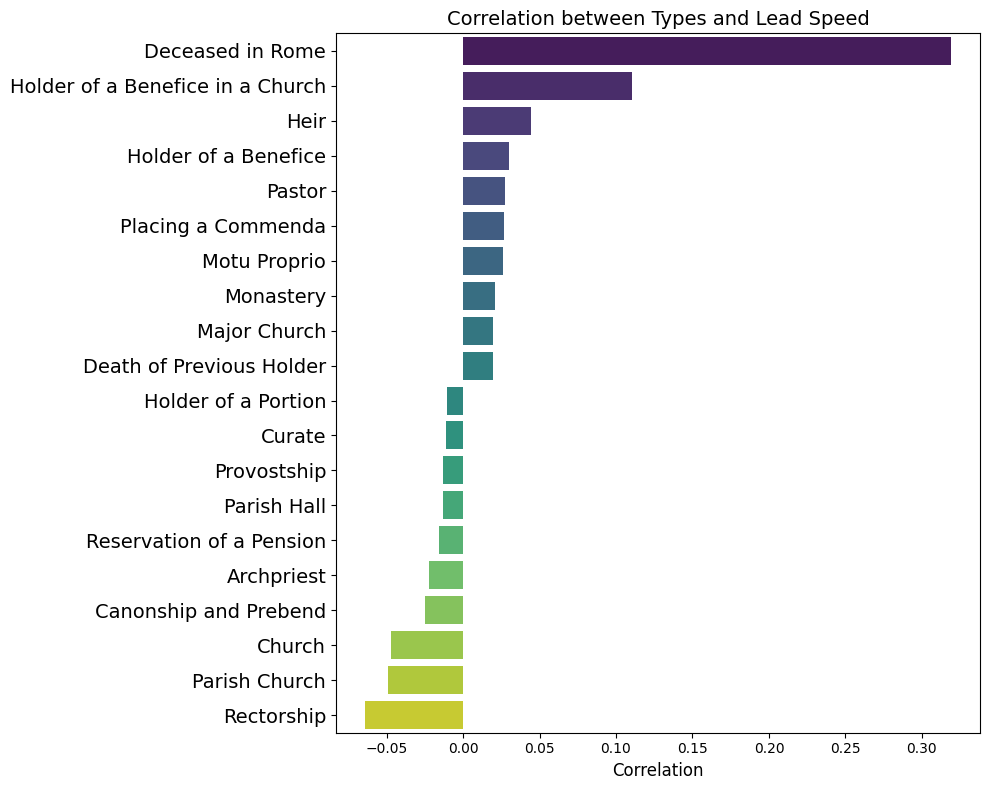

In [80]:
top_bottom_df.reset_index(inplace=True)
top_bottom_df.rename(columns={'index': 'Type_Label'}, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Correlation',
    y='Type_Label',
    data=top_bottom_df,
    hue='Type_Label',
    palette='viridis',
    legend=False
)
plt.title('Correlation between Types and Lead Speed', fontsize=14)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel(None)

ax = plt.gca()
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
ax.set_yticklabels([titlecase(label.get_text()) for label in ax.get_yticklabels()], fontsize=14)

plt.tight_layout()
plt.savefig(output_path_render + "Lead_Speed_Correlations_Types.png", dpi=300, format='png')
plt.show()

### Correlation Provinces vs. Lead Speed

In [81]:
type_dummies = df_t['province_label'].str.get_dummies(sep=',')
df_with_dummies = pd.concat([df_t, type_dummies], axis=1)
# Initialize a dictionary to store the correlations
correlations = {}

# Iterate over each category column and calculate the correlation
for column in type_dummies.columns:
    correlation, p_val = pearsonr(df_with_dummies[column], df_with_dummies['event_lead_speed'])
    correlations[column] = {'Correlation': correlation, 'P-Value': p_val}

# Convert the dictionary into a DataFrame for a clear presentation
correlation_df = pd.DataFrame.from_dict(correlations, orient='index')
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Select the top and bottom 10 correlations (including p-values)
top_bottom_df = pd.concat([correlation_df.head(10), correlation_df.tail(10)])

# Print the result
print(top_bottom_df)

                     Correlation       P-Value
Oristano (Sardinia)     0.166706  1.626484e-18
Messina                 0.099594  1.770470e-07
Seville                 0.097032  3.638535e-07
Brindisi                0.047047  1.381633e-02
Mechelen-Bruxelles      0.043206  2.377218e-02
Santiago                0.024534  1.993570e-01
Tarragona               0.024288  2.039133e-01
Toledo                  0.018495  3.333457e-01
Paris                   0.011440  5.495922e-01
Candia                  0.007809  6.829575e-01
Salerno                -0.013011  4.961675e-01
Ravenna                -0.013463  4.813324e-01
Rome                   -0.014487  4.486168e-01
Bari                   -0.016834  3.785773e-01
Bologna                -0.017093  3.712910e-01
Napoli                 -0.017604  3.571532e-01
Firenze                -0.017612  3.569478e-01
Genova                 -0.019286  3.130817e-01
Benevento              -0.022768  2.336761e-01
Exempt Diocese         -0.048760  1.071760e-02


C:\Users\c.sander\AppData\Local\Temp\ipykernel_30604\539664519.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


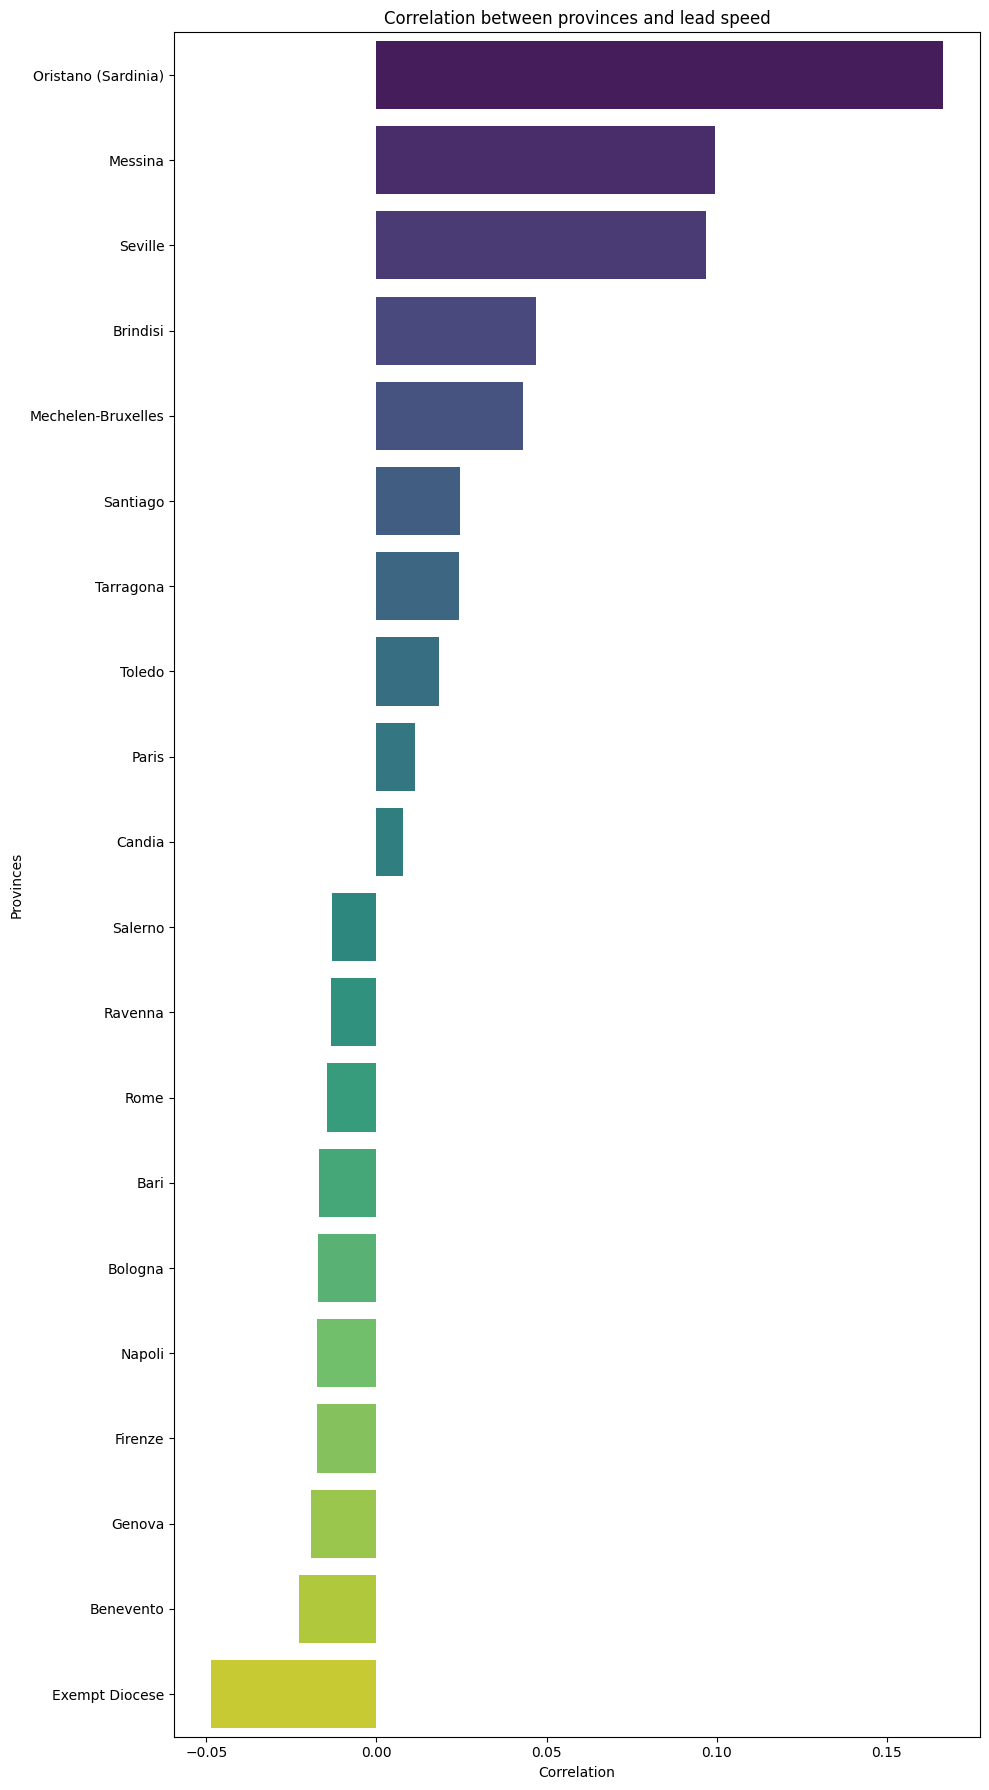

In [82]:
top_bottom_df.reset_index(inplace=True)
top_bottom_df.rename(columns={'index': 'province_label'}, inplace=True)
plt.figure(figsize=(10, 18))
sns.barplot(
    x='Correlation',
    y='province_label',
    data=top_bottom_df,
    palette='viridis'
)
plt.title('Correlation between provinces and lead speed')
plt.xlabel('Correlation')
plt.ylabel('Provinces')
plt.tight_layout()
plt.savefig(output_path_render + "Lead_Speed_Correlations_Provinces.png", dpi=300, format='png')
plt.show()

### Correlation Time Delta vs. Distance

In [256]:
# Calculation of the additional correlation

distance_time_delta_corr_log, p_val_log = pearsonr(np.log(df_sorted['distance']),(df_sorted['time_delta']))
distance_time_delta_corr, p_val = pearsonr((df_sorted['distance']),(df_sorted['time_delta']))

print("Correlation between distance and time_delta:")
print(distance_time_delta_corr, p_val)
print("Correlation between log of distance and time_delta:")
print(distance_time_delta_corr_log, p_val_log)

Correlation between distance and time_delta:
0.3026267944107609 4.3163523758966085e-59
Correlation between log of distance and time_delta:
0.29330101939784026 1.871489938006912e-55


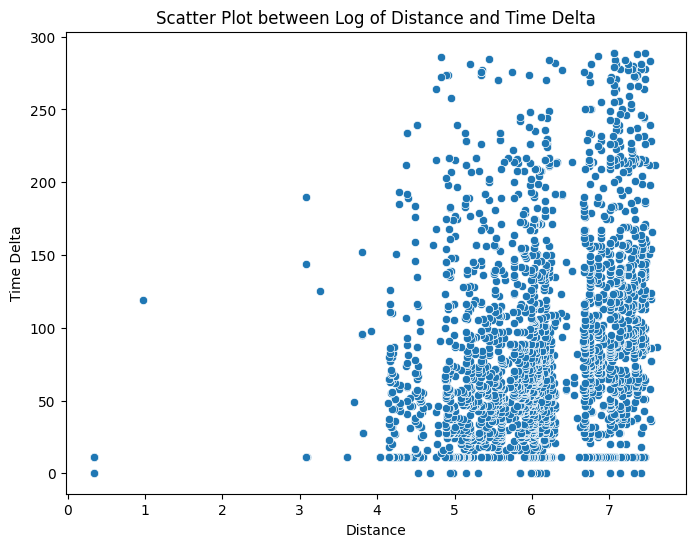

In [84]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sorted, x='log_distance', y='time_delta')
plt.title('Scatter Plot between Log of Distance and Time Delta')
plt.xlabel('Distance')
plt.ylabel('Time Delta')
plt.savefig(output_path_render + "Correlation_log_distance_time_delta.png", dpi=300, format='png')
plt.show()

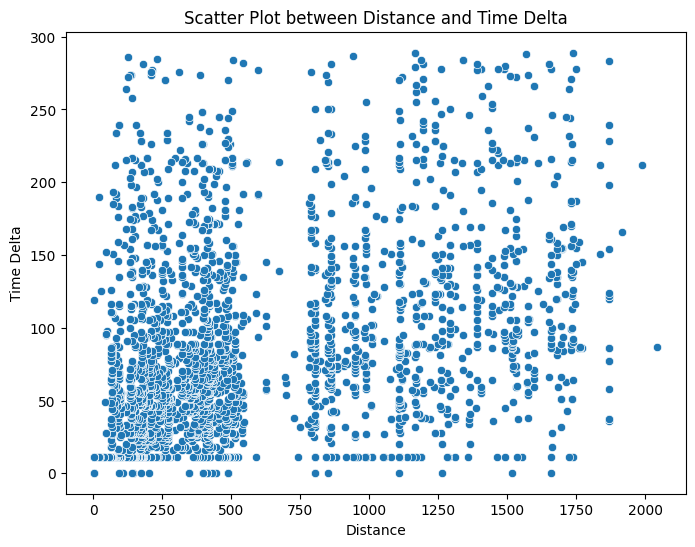

In [85]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sorted, x='distance', y='time_delta')
plt.title('Scatter Plot between Distance and Time Delta')
plt.xlabel('Distance')
plt.ylabel('Time Delta')
plt.savefig(output_path_render + "Correlation_distance_time_delta.png", dpi=300, format='png')
plt.show()

In [86]:
top_bottom_df.head(10)

,province_label,Correlation,P-Value
0,Oristano (Sardinia),0.166706,1.626484e-18
1,Messina,0.099594,1.770470e-07
2,Seville,0.097032,3.638535e-07
3,Brindisi,0.047047,1.381633e-02
4,Mechelen-Bruxelles,0.043206,2.377218e-02
5,Santiago,0.024534,1.993570e-01
6,Tarragona,0.024288,2.039133e-01
7,Toledo,0.018495,3.333457e-01
8,Paris,0.011440,5.495922e-01
9,Candia,0.007809,6.829575e-01


### Correlation Lead Speed vs. Distance

In [253]:
distance_lead_speed_corr_log, p_val_log = pearsonr(np.log(df_sorted['distance']),(df_sorted['event_lead_speed']))
distance_lead_speed_corr, p_val = pearsonr((df_sorted['distance']),(df_sorted['event_lead_speed']))

print("Correlation between distance and lead_speed:")
print(distance_lead_speed_corr, p_val)
print("Correlation between log of distance and lead_speed:")
print(distance_lead_speed_corr_log, p_val_log)

Correlation between distance and lead_speed:
0.06388475602554887 0.0008236631053541432
Correlation between log of distance and lead_speed:
0.06966876358767435 0.00026403310274750077


#### Lead Speed vs. Distance for Dioceses

In [255]:
distance_lead_speed_corr_log, p_val_log = pearsonr(np.log(diocese_stats['distance']),(diocese_stats['diocese_lead_speed']))
distance_lead_speed_corr, p_val = pearsonr((diocese_stats['distance']),(diocese_stats['event_lead_speed']))

print("Correlation between distance and lead_speed (Diocese):")
print(distance_lead_speed_corr, p_val)
print("Correlation between log of distance and lead_speed (Diocese):")
print(distance_lead_speed_corr_log, p_val_log)

Correlation between distance and lead_speed (Diocese):
0.15434968761476806 0.0032378075942434063
Correlation between log of distance and lead_speed (Diocese):
0.19994072514164257 0.0001282920171043991


### Correlation Date vs. Lead Speed

In [87]:
df_t = df_t.copy()
df_t.head()

,event,event_label,date_value_7,date_value_4,diocese_11,diocese_11_label,province,province_label,map_15,place_13,...,place_17_label,map_19,type_labels,time_delta,geometry_15,geometry_19,coords_15,coords_19,distance,event_lead_speed
0,https://g17.dhi-roma.it/resources/event_7157,APOSTOLIC PROVISION 7157,1678-05-16,1678-08-13,https://g17.dhi-roma.it/resources/institution_183,Cerviensis,https://g17.dhi-roma.it/resources/institution_891,Bologna,POINT (12.366666666667 44.25),https://g17.dhi-roma.it/resources/place_177,...,Basilica di Santa Maria Maggiore,POINT (12.498611111111 41.8975),"apostolic provision,papal grace,death of previ...",89.0,POINT (12.366666666667 44.25),POINT (12.498611111111 41.8975),"(44.25, 12.366666666667)","(41.8975, 12.498611111111)",261.569789,2.938986
2,https://g17.dhi-roma.it/resources/event_5482,APOSTOLIC PROVISION 5482,1621-07-16,1622-04-08,https://g17.dhi-roma.it/resources/institution_608,Vallisolitana,https://g17.dhi-roma.it/resources/institution_871,Toledo,POINT (-4.7285611111111 41.651980555556),https://g17.dhi-roma.it/resources/place_592,...,Rome,POINT (12.482777777778 41.893055555556),"apostolic provision,papal grace,death of previ...",266.0,POINT (-4.7285611111111 41.651980555556),POINT (12.482777777778 41.893055555556),"(41.651980555556, -4.7285611111111)","(41.893055555556, 12.482777777778)",1428.888629,5.371762
3,https://g17.dhi-roma.it/resources/event_6044,APOSTOLIC PROVISION 6044,1622-05-16,1622-07-18,https://g17.dhi-roma.it/resources/institution_275,Gandavensis,https://g17.dhi-roma.it/resources/institution_...,Mechelen-Bruxelles,POINT (3.725277777777778 51.05361111111111),https://g17.dhi-roma.it/resources/place_266,...,Basilica di Santa Maria Maggiore,POINT (12.498611111111 41.8975),"apostolic provision,papal grace,death of previ...",63.0,POINT (3.725277777777778 51.05361111111111),POINT (12.498611111111 41.8975),"(51.05361111111111, 3.725277777777778)","(41.8975, 12.498611111111)",1218.693526,19.344342
4,https://g17.dhi-roma.it/resources/event_4466,APOSTOLIC PROVISION 4466,1622-10-16,1623-01-13,https://g17.dhi-roma.it/resources/institution_566,Tirasonensis,https://g17.dhi-roma.it/resources/institution_869,Zaragoza,POINT (-1.7225 41.904444444444),https://g17.dhi-roma.it/resources/place_553,...,Rome,POINT (12.482777777778 41.893055555556),"apostolic provision,papal grace,death of previ...",89.0,POINT (-1.7225 41.904444444444),POINT (12.482777777778 41.893055555556),"(41.904444444444, -1.7225)","(41.893055555556, 12.482777777778)",1177.432011,13.229573
5,https://g17.dhi-roma.it/resources/event_4691,APOSTOLIC PROVISION 4691,1622-11-15,1623-02-10,https://g17.dhi-roma.it/resources/institution_259,Feruntina,https://g17.dhi-roma.it/resources/institution_877,Exempt Diocese,POINT (13.25 41.683333333333),https://g17.dhi-roma.it/resources/place_250,...,Rome,POINT (12.482777777778 41.893055555556),"apostolic provision,papal grace,death of previ...",87.0,POINT (13.25 41.683333333333),POINT (12.482777777778 41.893055555556),"(41.683333333333, 13.25)","(41.893055555556, 12.482777777778)",67.895816,0.780412


In [88]:
dep_var="event_lead_speed"
df_t["month"] = df_t["date_value_4"].apply(lambda d: d.strftime("%B") if d else None)
df_t["date_ordinal"] = df_t["date_value_4"].apply(lambda d: d.toordinal())
df_t[dep_var] = pd.to_numeric(df_t[dep_var], errors='coerce')
df_t = df_t.dropna(subset=[dep_var, 'date_ordinal'])

In [89]:
correlation, p_val = pearsonr(df_t["date_ordinal"], df_t[dep_var])
print(f"Correlation between 'combined_score' and 'date': {correlation}, {p_val}")

Correlation between 'combined_score' and 'date': 0.08801799257914601, 3.979087419252018e-06


In [90]:
grouped_data = df_t.groupby("month")[dep_var]
for month, scores in grouped_data:
    w, p = shapiro(scores)
    print(f"Shapiro test for {month}: W={w:.4f}, p={p:.4f}")

anova_groups = [scores for _, scores in grouped_data]
f_val, p_val = f_oneway(*anova_groups)
print(f"ANOVA: F={f_val:.4f}, p={p_val:.4f}")

Shapiro test for April: W=0.6433, p=0.0000
Shapiro test for August: W=0.2079, p=0.0000
Shapiro test for December: W=0.0817, p=0.0000
Shapiro test for February: W=0.1326, p=0.0000
Shapiro test for January: W=0.1078, p=0.0000
Shapiro test for July: W=0.1778, p=0.0000
Shapiro test for June: W=0.5038, p=0.0000
Shapiro test for March: W=0.1902, p=0.0000
Shapiro test for May: W=0.2665, p=0.0000
Shapiro test for November: W=0.6625, p=0.0000
Shapiro test for October: W=0.1130, p=0.0000
Shapiro test for September: W=0.1318, p=0.0000
ANOVA: F=3.3587, p=0.0001


In [91]:
data_month = pd.get_dummies(df_t, columns=["month"], drop_first=True)
dummy_cols = [col for col in data_month.columns if col.startswith("month_")]

In [92]:
correlations = {}
for col in dummy_cols:
    correlation, p_val = pearsonr(data_month[col], data_month[dep_var])
    correlations[col] = {'Correlation': correlation, 'P-Value': p_val}

import pandas as pd
corr_df = pd.DataFrame.from_dict(correlations, orient='index')
corr_df = corr_df.sort_values("Correlation", ascending=False)
print(corr_df)

                 Correlation   P-Value
month_February      0.082607  0.000015
month_May           0.055490  0.003679
month_August        0.019756  0.301422
month_October       0.015716  0.411069
month_July          0.001029  0.957059
month_March        -0.013924  0.466434
month_September    -0.015728  0.410715
month_January      -0.019025  0.319659
month_June         -0.025272  0.186174
month_December     -0.027109  0.156151
month_November     -0.034009  0.075200


In [93]:
data_month[dummy_cols] = data_month[dummy_cols].astype(int)
X = data_month[dummy_cols] # data_month.select_dtypes(include=[np.number]).drop(columns=[dep_var], errors="ignore")
y = data_month[dep_var]

# Create and adjust regression model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       event_lead_speed   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.359
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           0.000127
Time:                        12:46:11   Log-Likelihood:                -18008.
No. Observations:                2738   AIC:                         3.604e+04
Df Residuals:                    2726   BIC:                         3.611e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.3140     11.291     

## Plot

### Static Image

C:\Users\c.sander\AppData\Local\Temp\ipykernel_30604\383218207.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


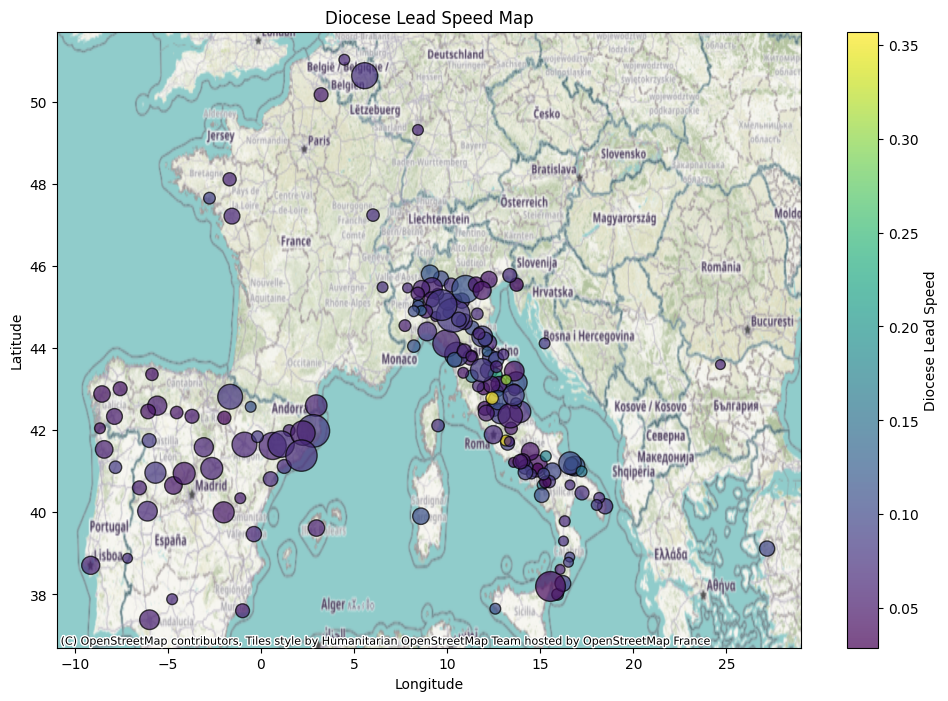

In [94]:
# Normalize the diocese_lead_speed for colormap
norm = Normalize(vmin=gdf_diocese['diocese_lead_speed'].min(), vmax=gdf_diocese['diocese_lead_speed'].max())
cmap = cm.get_cmap('viridis')

# Scale point sizes based on event_count
size_scale = 10  # Adjust this scaling factor as needed
gdf_diocese['point_size'] = gdf_diocese['event_count'] * size_scale

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot dioceses
sc = ax.scatter(
    gdf_diocese.geometry.x,
    gdf_diocese.geometry.y,
    s=gdf_diocese['point_size'],
    c=gdf_diocese['diocese_lead_speed'],
    cmap='viridis',
    norm=norm,
    alpha=0.7,
    edgecolor='k'
)

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Diocese Lead Speed')

# Add a title and labels
ax.set_title('Diocese Lead Speed Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

import contextily as ctx
ctx.add_basemap(ax, crs='EPSG:4326')
plt.savefig(output_path_render + "Diocese_Lead_Speed.png", dpi=300, format='png')
plt.show()


### Dynamic

#### Calculation

In [257]:
import logging

# Initialize the Geod object with WGS84 ellipsoid
geod = Geod(ellps='WGS84')

# Set up logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
MAX_EXPONENT = 700  # Value just below np.exp's limit
MAX_DISTANCE = 20000 #20037.5  # Maximum allowable distance in kilometers

# Determine the Target Lead Speed
if speed_diocese_lead_speed_agg=='median':
    target_lead_speed = diocese_stats['diocese_lead_speed'].median()
else:
    target_lead_speed = diocese_stats['diocese_lead_speed'].mean()

logger.info(f"Target Lead Speed: {target_lead_speed}")

target_distance = diocese_stats['distance'].mean()

def calculate_initial_compass_bearing(pointA: tuple, pointB: tuple) -> float:
    """
    Calculates the initial compass bearing (forward azimuth) between two points using pyproj.Geod.
    Points must be provided as (Latitude, Longitude) tuples.

    Args:
        pointA (tuple): The (latitude, longitude) of the starting point.
        pointB (tuple): The (latitude, longitude) of the destination point.

    Returns:
        float: The initial bearing in degrees from pointA to pointB.

    Raises:
        ValueError: If the two points are identical or coordinates are out of valid range.
    """
    lat1, lon1 = pointA
    lat2, lon2 = pointB

    # Validate input coordinates
    if not (-90 <= lat1 <= 90 and -90 <= lat2 <= 90):
        raise ValueError("Latitudes must be between -90° and 90°.")
    if not (-180 <= lon1 <= 180 and -180 <= lon2 <= 180):
        raise ValueError("Longitudes must be between -180° and 180°.")
    if (lat1, lon1) == (lat2, lon2):
        raise ValueError("The two points are identical; the initial bearing is undefined.")

    # Calculate forward azimuth, back azimuth, and distance
    azimuth, back_azimuth, distance = geod.inv(lon1, lat1, lon2, lat2)

    # Ensure azimuth is between 0° and 360°
    initial_bearing = azimuth % 360

    return initial_bearing

def compute_antipode(point: tuple) -> tuple:
    """
    Calculates the antipode of a given point.

    Args:
        point (tuple): (latitude, longitude) of the original point.

    Returns:
        tuple: (latitude, longitude) of the antipode.
    """
    lat, lon = point
    antipode_lat = -lat
    antipode_lon = (lon + 180) % 360 - 180
    return (antipode_lat, antipode_lon)

def compute_adjusted_location(row: pd.Series, df: pd.DataFrame) -> tuple:
    """
    Computes the adjusted location for a diocese based on event data and returns the centroid.

    Args:
        row (pd.Series): A row from the GeoDataFrame containing diocese information.
        df (pd.DataFrame): DataFrame containing event data.

    Returns:
        tuple: A tuple containing the adjusted geometry (ShapelyPoint), the centroid (ShapelyPoint),
               and an info dictionary.
    """
    diocese_point = row['geometry_15']
    if diocese_point is None:
        return None, None, {}

    diocese_coords = (diocese_point.y, diocese_point.x)  # (lat, lon)
    diocese_id = row['diocese_11']

    # Filter events related to the current diocese with non-null geometry
    events = df[(df['diocese_11'] == diocese_id) & df['geometry_19'].notnull()]
    event_coords = events['geometry_19'].apply(lambda p: (p.y, p.x)).tolist()

    if len(event_coords) == 0:
        return None, None, {}

    # Calculate the centroid of the event coordinates
    event_latitudes = [coord[0] for coord in event_coords]
    event_longitudes = [coord[1] for coord in event_coords]
    centroid_lat = np.mean(event_latitudes)
    centroid_lon = np.mean(event_longitudes)
    centroid = (centroid_lat, centroid_lon)
    centroid_point = ShapelyPoint(centroid_lon, centroid_lat)  # Shapely Point for centroid

    # Calculate the current distance between the diocese and the centroid
    current_distance = geodesic(diocese_coords, centroid).kilometers

    # Retrieve the time delta
    time_delta = row['time_delta']
    if pd.isna(time_delta) or time_delta <= 0:
        return None, centroid_point, {}

    # Calculate the required distance using exponential scaling if log
    if distance_log:
        required_distance_real = np.exp(np.clip(target_lead_speed * time_delta, -MAX_EXPONENT, MAX_EXPONENT))
    else:
        required_distance_real = target_lead_speed * time_delta

    scaling_factor =  target_lead_speed / row['diocese_lead_speed']
    # scaling_factor = required_distance / current_distance # alternative

    required_distance = required_distance_real
    required_distance = min(required_distance, MAX_DISTANCE) # half Earth diameter cap

    # Initialize the info dictionary with mandatory fields
    info = {
        'Diocese Label': row['diocese_11_label'],
        'Time Delta': time_delta,
        'Current Distance': current_distance,
        'Required Distance': required_distance_real,
        'Scaling Factor': scaling_factor,
        'Target Lead Speed': target_lead_speed,
        'Calculated Lead Speed': row['diocese_lead_speed'],
        '# Events':row['event_count']
    }

    # Conditionally include 'Required Distance (uncorrected)' if different from 'Required Distance'
    # if required_distance_real != required_distance:
    #     info['Required Distance (uncorrected)'] = required_distance_real
    if required_distance >= MAX_DISTANCE:
        info['Distance (projected)'] = required_distance
        # adjusted_coords = compute_antipode(diocese_coords)
        # adjusted_shapely_point = ShapelyPoint(adjusted_coords[1], adjusted_coords[0])
        # return adjusted_shapely_point, centroid_point, info

    # Handle cases where the current distance is NaN
    if pd.isna(current_distance):
        return None, centroid_point, {}

    # Check for zero distance
    if current_distance == 0:
        return diocese_point, centroid_point, info

    # Calculate the difference between required and current distances
    distance_difference = required_distance - current_distance

    # Define a tolerance threshold
    epsilon = 1e-6

    # If the distance difference is negligible, no adjustment is needed
    if abs(distance_difference) <= epsilon:
        return diocese_point, centroid_point, info

    # Calculate the initial bearing from the diocese to the centroid
    initial_bearing = calculate_initial_compass_bearing(diocese_coords, centroid)

    # Adjust the bearing based on the direction of movement
    if distance_difference > 0:
        # Diocese needs to move away from the centroid; reverse the bearing by 180 degrees
        adjusted_bearing = (initial_bearing + 180) % 360
    else:
        # Diocese needs to move towards the centroid; keep the initial bearing
        adjusted_bearing = initial_bearing

    # Determine the movement distance as the absolute difference
    movement_distance = abs(distance_difference)

    # Define the diocese coordinates as a tuple (latitude, longitude)
    diocese_coords_tuple = (diocese_coords[0], diocese_coords[1])  # (lat, lon)

    # Calculate the new adjusted location using geodesic distance and bearing
    adjusted_location = geodesic(kilometers=movement_distance).destination(
        point=diocese_coords_tuple, bearing=adjusted_bearing
    )

    # Create a Shapely Point for the adjusted location
    adjusted_shapely_point = ShapelyPoint(adjusted_location.longitude, adjusted_location.latitude)

    return adjusted_shapely_point, centroid_point, info

# Ensure that 'geometry_15' is set as the active geometry in the GeoDataFrame
gdf_diocese = gdf_diocese.set_geometry('geometry_15')

# Initialize lists to store adjusted geometries, centroids, and additional info
adjusted_geometries = []
centroids = []
infos = []

# Iterate over each row in the diocese GeoDataFrame
for idx, row in gdf_diocese.iterrows():
    adjusted_geometry, centroid, info = compute_adjusted_location(row, df)
    adjusted_geometries.append(adjusted_geometry)
    centroids.append(centroid)
    infos.append(info)

# Add the adjusted geometries, centroids, and info to the GeoDataFrame
gdf_diocese['adjusted_geometry'] = adjusted_geometries
gdf_diocese['centroid'] = centroids
gdf_diocese['info'] = infos

# Remove rows without adjusted geometry
gdf_diocese = gdf_diocese.dropna(subset=['adjusted_geometry'])

# gdf_diocese['distance_diff'] = gdf_diocese['info'].apply(lambda x: x['Required Distance'] - x['Current Distance'])
# min_diff = gdf_diocese['distance_diff'].min()
# max_diff = gdf_diocese['distance_diff'].max()
# norm = mcolors.Normalize(vmin=min_diff, vmax=max_diff)
# cmap = cm.get_cmap('viridis')

# Create GeoDataFrame for actual geometries
gdf_actual = gdf_diocese[['diocese_11', 'diocese_11_label', 'geometry_15', 'info']].copy()
gdf_actual = gdf_actual.rename(columns={'geometry_15': 'geometry'})
gdf_actual['type'] = 'Actual'
gdf_actual = gpd.GeoDataFrame(gdf_actual, geometry='geometry', crs='EPSG:4326')

# Create GeoDataFrame for adjusted geometries
gdf_adjusted = gdf_diocese[['diocese_11', 'diocese_11_label', 'adjusted_geometry', 'info']].copy()
gdf_adjusted = gdf_adjusted.rename(columns={'adjusted_geometry': 'geometry'})
gdf_adjusted['type'] = 'Adjusted'
gdf_adjusted = gpd.GeoDataFrame(gdf_adjusted, geometry='geometry', crs='EPSG:4326')

# Create GeoDataFrame for centroids
gdf_centroids = gdf_diocese[['diocese_11', 'diocese_11_label', 'centroid', 'info']].copy()
gdf_centroids = gdf_centroids.rename(columns={'centroid': 'geometry'})
gdf_centroids['type'] = 'Centroid'
gdf_centroids = gpd.GeoDataFrame(gdf_centroids, geometry='geometry', crs='EPSG:4326')

# Optional: Reproject to EPSG:3857 if using ctx.add_basemap or other web-based mapping tools
gdf_actual = gdf_actual.to_crs('EPSG:3857')
gdf_adjusted = gdf_adjusted.to_crs('EPSG:3857')
gdf_centroids = gdf_centroids.to_crs('EPSG:3857')

# Combine the actual, adjusted, and centroid GeoDataFrames
gdf_combined = pd.concat([gdf_actual, gdf_adjusted, gdf_centroids], ignore_index=True)

# Optionally, reset the geometry if needed
gdf_combined = gpd.GeoDataFrame(gdf_combined, geometry='geometry', crs='EPSG:3857')

# Example: Display the first few rows of the combined GeoDataFrame
logger.info("Combined GeoDataFrame:")
logger.info(gdf_combined.head())


INFO:__main__:Target Lead Speed: 8.508559030046221
INFO:__main__:Combined GeoDataFrame:
INFO:__main__:                                          diocese_11 diocese_11_label  \
0  https://g17.dhi-roma.it/resources/institution_100         Barensis   
1  https://g17.dhi-roma.it/resources/institution_...       Casalensis   
2  https://g17.dhi-roma.it/resources/institution_107      Beneventana   
3  https://g17.dhi-roma.it/resources/institution_108      Bergomensis   
4  https://g17.dhi-roma.it/resources/institution_111        Bisuntina   

                          geometry  \
0  POINT (1877588.745 5030837.706)   
1     POINT (941577.36 5642668.07)   
2  POINT (1645673.139 5032028.237)   
3  POINT (1076459.476 5731606.747)   
4   POINT (670297.945 5981700.915)   

                                                info    type  
0  {'Diocese Label': 'Barensis', 'Time Delta': 55...  Actual  
1  {'Diocese Label': 'Casalensis', 'Time Delta': ...  Actual  
2  {'Diocese Label': 'Beneventana', 'Time

#### Network

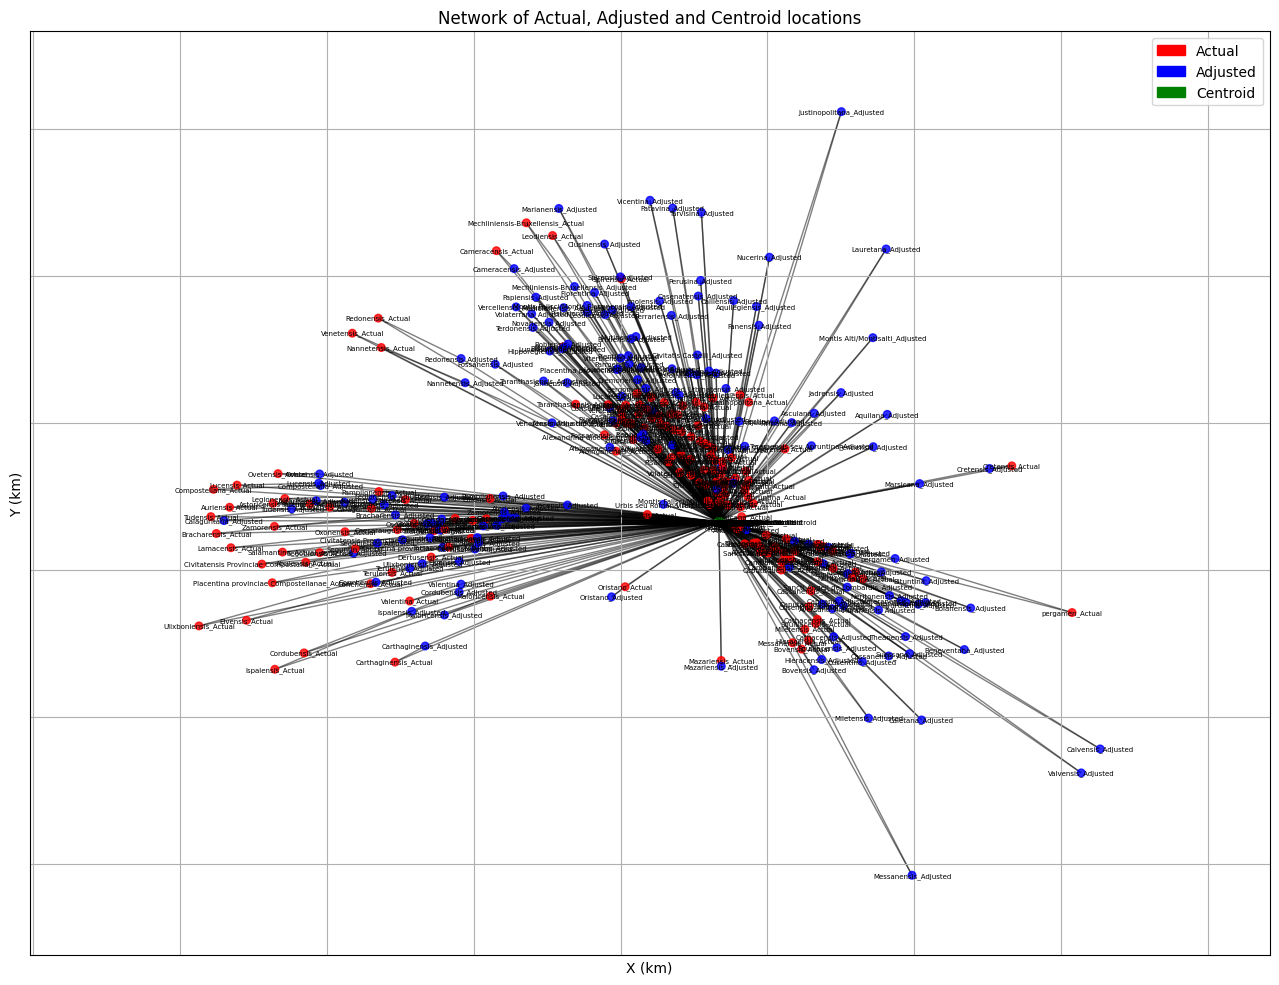

In [258]:
from pyproj import Proj, transform
import networkx as nx

mean_lat = gdf_diocese['geometry_15'].y.mean()
mean_lon = gdf_diocese['geometry_15'].x.mean()

proj_equirect = Proj(proj='eqc', lat_ts=mean_lat, lon_0=mean_lon, units='km')

def project_point(point):
    x, y = proj_equirect(point.x, point.y)
    return (x, y)

gdf_diocese['actual_xy'] = gdf_diocese['geometry_15'].apply(project_point)
gdf_diocese['adjusted_xy'] = gdf_diocese['adjusted_geometry'].apply(project_point)
gdf_diocese['centroid_xy'] = gdf_diocese['centroid'].apply(project_point)


G = nx.Graph()

for idx, row in gdf_diocese.iterrows():
    diocese_label = row['diocese_11_label']

    actual_node = f"{diocese_label}_Actual"
    adjusted_node = f"{diocese_label}_Adjusted"
    centroid_node = f"{diocese_label}_Centroid"

    # Adding nodes with position attributes
    G.add_node(actual_node, pos=row['actual_xy'], type='Actual')
    G.add_node(adjusted_node, pos=row['adjusted_xy'], type='Adjusted')
    G.add_node(centroid_node, pos=row['centroid_xy'], type='Centroid')

    # Adding the edges with weight (distance in km)
    distance_actual_adjusted = geodesic(
        (row['geometry_15'].y, row['geometry_15'].x),
        (row['adjusted_geometry'].y, row['adjusted_geometry'].x)
    ).kilometers
    distance_actual_centroid = geodesic(
        (row['geometry_15'].y, row['geometry_15'].x),
        (row['centroid'].y, row['centroid'].x)
    ).kilometers
    distance_adjusted_centroid = geodesic(
        (row['adjusted_geometry'].y, row['adjusted_geometry'].x),
        (row['centroid'].y, row['centroid'].x)
    ).kilometers

    G.add_edge(actual_node, adjusted_node, weight=distance_actual_adjusted)
    G.add_edge(actual_node, centroid_node, weight=distance_actual_centroid)
    G.add_edge(adjusted_node, centroid_node, weight=distance_adjusted_centroid)

# Retrieving the positions of the nodes
pos = nx.get_node_attributes(G, 'pos')

# Determining the node types for the coloring
node_types = nx.get_node_attributes(G, 'type')
color_map = {'Actual': 'red', 'Adjusted': 'blue', 'Centroid': 'green'}
node_colors = [color_map[node_types[node]] for node in G.nodes()]

# Plot the network
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=5, font_family="sans-serif")

# Create legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Adjusted')
green_patch = mpatches.Patch(color='green', label='Centroid')
plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.title('Network of Actual, Adjusted and Centroid locations')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.grid(True)
plt.axis('equal')  # Same scaling on both axes
plt.show()


#### Create Folium Maps

##### Dynamic Markers

inspired by https://fitzlab.shinyapps.io/cityapp/

In [260]:
# Custom class to inject JavaScript for interactivity
class ClickForMore(MacroElement):
    """
    Custom Folium MacroElement to handle interactivity for markers and polylines.
    Clicking on the actual marker toggles the visibility of adjusted marker, centroid marker,
    and the connecting geodetic lines.
    """
    def __init__(self, marker_actual_name, marker_adjusted_name, marker_centroid_name,
                 line_actual_adjusted_name, line_actual_centroid_name, line_adjusted_centroid_name,
                 map_object_name):
        """
        Initializes the ClickForMore class.

        Args:
            marker_actual_name (str): JavaScript variable name for the actual marker.
            marker_adjusted_name (str): JavaScript variable name for the adjusted marker.
            marker_centroid_name (str): JavaScript variable name for the centroid marker.
            line_actual_adjusted_name (str): JavaScript variable name for the actual-adjusted polyline.
            line_actual_centroid_name (str): JavaScript variable name for the actual-centroid polyline.
            line_adjusted_centroid_name (str): JavaScript variable name for the adjusted-centroid polyline.
            map_object_name (str): JavaScript variable name for the map object.
        """
        super(ClickForMore, self).__init__()
        self._name = 'ClickForMore'
        self.marker_actual_name = marker_actual_name
        self.marker_adjusted_name = marker_adjusted_name
        self.marker_centroid_name = marker_centroid_name
        self.line_actual_adjusted_name = line_actual_adjusted_name
        self.line_actual_centroid_name = line_actual_centroid_name
        self.line_adjusted_centroid_name = line_adjusted_centroid_name
        self.map_object_name = map_object_name

        # Define the JavaScript template
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
        (function(){
            // Initially remove the adjusted marker, centroid marker, and polylines to hide them
            {{ this.marker_adjusted_name | safe }}.remove();
            {{ this.marker_centroid_name | safe }}.remove();
            {{ this.line_actual_adjusted_name | safe }}.remove();
            {{ this.line_actual_centroid_name | safe }}.remove();
            {{ this.line_adjusted_centroid_name | safe }}.remove();

            // Add click event to the actual marker
            {{ this.marker_actual_name | safe }}.on('click', function(){
                if ({{ this.map_object_name | safe }}.hasLayer({{ this.marker_adjusted_name | safe }})) {
                    // If layers are already added, remove them
                    {{ this.map_object_name | safe }}.removeLayer({{ this.marker_adjusted_name | safe }});
                    {{ this.map_object_name | safe }}.removeLayer({{ this.marker_centroid_name | safe }});
                    {{ this.map_object_name | safe }}.removeLayer({{ this.line_actual_adjusted_name | safe }});
                    {{ this.map_object_name | safe }}.removeLayer({{ this.line_actual_centroid_name | safe }});
                    {{ this.map_object_name | safe }}.removeLayer({{ this.line_adjusted_centroid_name | safe }});
                } else {
                    // If layers are not added, add them
                    {{ this.marker_adjusted_name | safe }}.addTo({{ this.map_object_name | safe }});
                    {{ this.marker_centroid_name | safe }}.addTo({{ this.map_object_name | safe }});
                    {{ this.line_actual_adjusted_name | safe }}.addTo({{ this.map_object_name | safe }});
                    {{ this.line_actual_centroid_name | safe }}.addTo({{ this.map_object_name | safe }});
                    {{ this.line_adjusted_centroid_name | safe }}.addTo({{ this.map_object_name | safe }});
                }
            });
        })();
        {% endmacro %}
        """)

def great_circle_points(start: tuple, end: tuple, num_points: int = 100) -> list:
    """
    Generates intermediate points along a great circle path between start and end.

    Args:
        start (tuple): (latitude, longitude) of the start point.
        end (tuple): (latitude, longitude) of the end point.
        num_points (int, optional): Number of intermediate points. Defaults to 100.

    Returns:
        list: List of (latitude, longitude) tuples along the great circle path.
    """
    points = []
    total_distance = geodesic(start, end).km
    try:
        initial_bearing = calculate_initial_compass_bearing(start, end)
    except ValueError:
        # If points are identical, return a single point
        return [start]

    for i in range(num_points + 1):
        fraction = i / num_points
        distance = total_distance * fraction
        intermediate_point = geodesic(kilometers=distance).destination(start, initial_bearing)
        points.append((intermediate_point.latitude, intermediate_point.longitude))
    return points

FIXED_MIN_DIFF = -MAX_DISTANCE
FIXED_MAX_DIFF = MAX_DISTANCE

min_radius = 5
max_radius = 15

n_events_values = gdf_diocese['event_count'].tolist()
min_n_events = min(n_events_values)
max_n_events = max(n_events_values)

def normalize_radius(n, min_n, max_n, min_r, max_r):
    if max_n == min_n:
        return (min_r + max_r) / 2
    else:
        return min_r + (n - min_n) / (max_n - min_n) * (max_r - min_r)

lead_speeds = gdf_diocese['info'].apply(lambda x: x.get('Calculated Lead Speed', 0)).tolist()

FIXED_MIN_LEAD_SPEED = min(lead_speeds)
FIXED_MAX_LEAD_SPEED = max(lead_speeds)

mean_lat = gdf_diocese['geometry_15'].y.mean()
mean_lon = gdf_diocese['geometry_15'].x.mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=2)

colormap = cm_colormap.LinearColormap(
    colors=['red', 'yellow', 'green'],
    index=[FIXED_MIN_LEAD_SPEED,
           target_lead_speed,
           FIXED_MAX_LEAD_SPEED],
    vmin=FIXED_MIN_LEAD_SPEED,
    vmax=FIXED_MAX_LEAD_SPEED,
    caption='Calculated Lead Speed'
)
colormap.add_to(m)

# FeatureGroup for actual positions
actual_group = FeatureGroup(name='Actual Positions')
m.add_child(actual_group)

# Get the map's JavaScript variable name
map_object_name = m.get_name()

# Iterate over each row in the diocese GeoDataFrame
for idx, row in gdf_diocese.iterrows():
    # Actual position coordinates
    actual_point = row['geometry_15']
    if actual_point is None:
        continue  # Skip if actual geometry is missing
    lat_actual = actual_point.y
    lon_actual = actual_point.x
    diocese_label = row['diocese_11_label']

    # Adjusted position coordinates
    adjusted_point = row['adjusted_geometry']
    if adjusted_point is None:
        continue  # Skip if adjusted geometry is missing
    lat_adjusted = adjusted_point.y
    lon_adjusted = adjusted_point.x

    # Centroid coordinates
    centroid_point = row['centroid']
    if centroid_point is not None:
        lat_centroid = centroid_point.y
        lon_centroid = centroid_point.x
    else:
        lat_centroid = None
        lon_centroid = None

    # Information dictionary
    info = row['info']

    # Determine marker color based on Required Distance
    time_delta = info.get('Time Delta', None)
    required_distance = info.get('Required Distance', 0)
    lead_speed = info.get('Calculated Lead Speed', 0)
    current_distance = info.get('Current Distance', 0)
    required_distance_projected = info.get('Distance (projected)', None)
    size_scale = 10  # Adjust this scaling factor as needed
    n_events = info.get('# Events', 1)

    difference = current_distance - required_distance
    hex_color = colormap(lead_speed)
    marker_color = hex_color

    icon_color = 'yellow'
    if required_distance < current_distance:
      icon_color = 'green'

    # Create the tooltip content for the actual marker
    tooltip_content = f"""
    <b>{diocese_label} (Actual)</b><br>
    Time Delta: {time_delta:.2f} days ({time_diocese_lead_speed_agg})<br>
    Current Distance: {current_distance:.2f} km<br>
    Required Distance: {required_distance:.2f} km<br>
    Difference in Distance: {difference:.2f} km<br>
    Lead Speed: {lead_speed:.5f} ({speed_diocese_lead_speed_agg}) (global {speed_diocese_lead_speed_agg}: {target_lead_speed:.5f})<br>
    Scaling Factor: {info.get('Scaling Factor', 1):.4f}<br>
    Number of Events: {n_events:.0f}<br>
    """

    # Conditionally include 'Required Distance (projected)' if present
    if required_distance_projected is not None:
        marker_color = 'FF0000'
        icon_color = 'red'
        tooltip_content += f"Distance (projected): {required_distance_projected:.2f} km<br>"


    # Create the actual marker with conditional color
    marker_actual = folium.CircleMarker(
        location=[lat_actual, lon_actual],
        radius=normalize_radius(n_events, min_n_events, max_n_events, min_radius, max_radius),
        color=icon_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.9,
        popup=folium.Popup(tooltip_content, max_width=300),
        zIndexOffset=2500
    )
    marker_actual.add_to(actual_group)


    # Create the centroid marker (hidden initially)
    if lat_centroid is not None and lon_centroid is not None:
        tooltip_centroid = f"""
        <b>{diocese_label} (Centroid)</b><br>
        Centroid Location: ({lat_centroid:.4f}, {lon_centroid:.4f})<br>
        """
        marker_centroid = folium.Marker(
            location=[lat_centroid, lon_centroid],
            popup=folium.Popup(tooltip_centroid, max_width=200),
            icon=folium.Icon(color='green', icon='star'),
            zIndexOffset=500
        )
        marker_centroid.add_to(m)  # Must add to map to generate JavaScript variable
    else:
        marker_centroid = None

    # Create the adjusted marker (hidden initially)
    tooltip_adjusted = f"""
    <b>{diocese_label} (Adjusted)</b><br>
    Time Delta: {time_delta:.2f} days ({time_diocese_lead_speed_agg})<br>
    Current Distance: {current_distance:.2f} km<br>
    Required Distance: {required_distance:.2f} km<br>
    Difference in Distance: {difference:.2f} km<br>
    Lead Speed: {lead_speed:.5f} ({speed_diocese_lead_speed_agg}) (global {speed_diocese_lead_speed_agg}: {target_lead_speed:.5f})<br>
    Scaling Factor: {info.get('Scaling Factor', 1):.4f}<br>
    """
    if required_distance_projected is not None:
        tooltip_adjusted += f"Distance (projected): {required_distance_projected:.2f} km<br>"

    marker_adjusted = folium.Marker(
        location=[lat_adjusted, lon_adjusted],
        popup=folium.Popup(tooltip_adjusted, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign'),
        zIndexOffset=1500
    )
    marker_adjusted.add_to(m)  # Must add to map to generate JavaScript variable


    # Generate geodetic (great circle) lines between actual and adjusted positions
    gc_line_actual_adjusted = great_circle_points(
        start=(lat_actual, lon_actual),
        end=(lat_adjusted, lon_adjusted),
        num_points=100
    )
    polyline_actual_adjusted = folium.PolyLine(
        locations=gc_line_actual_adjusted,
        color='gray',
        weight=2,
        opacity=0.6
    )
    polyline_actual_adjusted.add_to(m)  # Must add to map to generate JavaScript variable

    # Generate geodetic (great circle) lines between actual and centroid
    if lat_centroid is not None and lon_centroid is not None:
        gc_line_actual_centroid = great_circle_points(
            start=(lat_actual, lon_actual),
            end=(lat_centroid, lon_centroid),
            num_points=100
        )
        polyline_actual_centroid = folium.PolyLine(
            locations=gc_line_actual_centroid,
            color='gray',
            weight=2,
            opacity=0.6
        )
        polyline_actual_centroid.add_to(m)
    else:
        polyline_actual_centroid = None

    # Generate geodetic (great circle) lines between adjusted and centroid
    if lat_centroid is not None and lon_centroid is not None:
        gc_line_adjusted_centroid = great_circle_points(
            start=(lat_adjusted, lon_adjusted),
            end=(lat_centroid, lon_centroid),
            num_points=100
        )
        polyline_adjusted_centroid = folium.PolyLine(
            locations=gc_line_adjusted_centroid,
            color='gray',
            weight=2,
            opacity=0.6
        )
        polyline_adjusted_centroid.add_to(m)
    else:
        polyline_adjusted_centroid = None

    # Retrieve the JavaScript variable names assigned by Folium
    marker_actual_id = marker_actual.get_name()
    marker_adjusted_id = marker_adjusted.get_name()
    line_actual_adjusted_id = polyline_actual_adjusted.get_name()
    if polyline_actual_centroid:
        line_actual_centroid_id = polyline_actual_centroid.get_name()
    else:
        line_actual_centroid_id = None
    if polyline_adjusted_centroid:
        line_adjusted_centroid_id = polyline_adjusted_centroid.get_name()
    else:
        line_adjusted_centroid_id = None
    if marker_centroid:
        marker_centroid_id = marker_centroid.get_name()
    else:
        marker_centroid_id = None

    # Only proceed if centroid and lines exist
    if marker_centroid_id and line_actual_centroid_id and line_adjusted_centroid_id:
        # Add the custom JavaScript to the map for interactivity
        click_for_more = ClickForMore(
            marker_actual_name=marker_actual_id,
            marker_adjusted_name=marker_adjusted_id,
            marker_centroid_name=marker_centroid_id,
            line_actual_adjusted_name=line_actual_adjusted_id,
            line_actual_centroid_name=line_actual_centroid_id,
            line_adjusted_centroid_name=line_adjusted_centroid_id,
            map_object_name=map_object_name
        )
        m.get_root().add_child(click_for_more)
    else:
        # Handle cases where centroid or lines are missing
        pass

info_html = """
<style>
    /* Style for the Info Box */
    #info-box {
        position: fixed;
        top: 10px;
        left: 100px;
        width: 300px;
        background-color: white;
        border:2px solid grey;
        z-index:9999;
        font-family: Arial, sans-serif;
        font-size: 14px;
        padding: 10px;
        border-radius: 5px;
        box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
        display: block; /* Initially visible */
    }
    /* Style for the Toggle Button */
    #toggle-info-btn {
        position: fixed;
        top: 10px;
        left: 100px;
        z-index:10000;
        background-color: #fff;
        border: 2px solid grey;
        border-radius: 5px;
        padding: 5px 10px;
        cursor: pointer;
        font-family: Arial, sans-serif;
        font-size: 14px;
        box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    }
</style>

<!-- Info Box -->
<div id="info-box">
    <div style="display: flex; justify-content: space-between; align-items: center;">
        <h4>Map Overview</h4>
        <button onclick="toggleInfoBox()" style="background: none; border: none; font-size: 16px; cursor: pointer;">&times;</button>
    </div>
    <p>This interactive map visualizes the so-called lead speed of various dioceses — a proxy for administrative efficiency, calculated by relating the time taken to process all their submitted provisions to the distance over which this processing occurred.</p>

    <p>Each circle marks a diocese at its diocesan town. The color of the circle places the diocese on a continuous spectrum of lead speed values, relative to all others. Dioceses operating above the global average speed are highlighted with a green outer ring, while those below average are marked with a yellow ring.</p>

    <p>The radius of each circle reflects the number of provisions included in the calculation.</p>

    <p>Clicking on a diocese triggers a simulation: the map calculates where the diocese would be located if it operated at the global average speed, based on its average time to procure provisions. More efficient dioceses will appear closer to their actual centers of activity. To keep results meaningful, the calculated distance is capped at half the Earth's diameter.</p>

    <p>For more details, visit our <a href="https://dataria.org" target="_blank">website</a>.</p>
</div>

<!-- Toggle Button (Visible when Info Box is Hidden) -->
<button id="toggle-info-btn" onclick="toggleInfoBox()" style="display: none;">Info</button>

<script>
// Function to toggle the visibility of the Info Box and Toggle Button
function toggleInfoBox() {
    var infoBox = document.getElementById('info-box');
    var toggleBtn = document.getElementById('toggle-info-btn');
    if (infoBox.style.display === 'none') {
        infoBox.style.display = 'block';
        toggleBtn.style.display = 'none';
    } else {
        infoBox.style.display = 'none';
        toggleBtn.style.display = 'block';
    }
}
</script>
"""

from folium import Element
m.get_root().html.add_child(Element(info_html))

# Add LayerControl to toggle feature groups
# folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save(output_path_render + 'lead_speed.html')


##### Marker Pairs

In [262]:
# Create the base map
m = folium.Map(location=[0, 0], zoom_start=2)

# Main group for actual positions
actual_group = FeatureGroup(name='Actual positions')
m.add_child(actual_group)

for idx, row in gdf_diocese.iterrows():
    # Create a FeatureGroup for the pair
    pair_group = folium.FeatureGroup(name=f'Pair {diocese_label}', show=False)
    m.add_child(pair_group)

    # Actual position
    lat_actual = row['geometry_15'].y
    lon_actual = row['geometry_15'].x
    diocese_label = row['diocese_11_label']

    # Adjusted position
    lat_adjusted = row['adjusted_geometry'].y
    lon_adjusted = row['adjusted_geometry'].x

    # Actual marker
    marker_actual = folium.Marker(
        location=[lat_actual, lon_actual],
        popup=f"<b>{diocese_label}</b><br>Actual position",
        icon=folium.Icon(color='blue')
    )
    marker_actual.add_to(pair_group)

    # Adjusted marker
    marker_adjusted = folium.Marker(
        location=[lat_adjusted, lon_adjusted],
        popup=f"<b>{diocese_label}</b><br>Virtual position",
        icon=folium.Icon(color='red')
    )
    marker_adjusted.add_to(pair_group)

    # Line between the points
    line = folium.PolyLine(
        locations=[[lat_actual, lon_actual], [lat_adjusted, lon_adjusted]],
        color='gray',
        weight=2,
        opacity=0.6
    )
    line.add_to(pair_group)

# Add LayerControl
folium.LayerControl().add_to(m)

# Save the map
m.save(output_path_render + 'lead_speed_pair.html')


## Data Table and Insights

In [100]:
df_sorted.head(10000)

,event,event_label,date_value_7,date_value_4,diocese_11,diocese_11_label,province,province_label,map_15,place_13,...,map_19,type_labels,time_delta,geometry_15,geometry_19,coords_15,coords_19,distance,event_lead_speed,log_distance
1158,https://g17.dhi-roma.it/resources/event_4635,APOSTOLIC PROVISION 4635,1623-02-03,1623-02-03,https://g17.dhi-roma.it/resources/institution_305,Ispalensis,https://g17.dhi-roma.it/resources/institution_872,Seville,POINT (-5.9833333333333 37.383333333333),https://g17.dhi-roma.it/resources/place_296,...,POINT (12.482777777778 41.893055555556),"deceased in Rome,apostolic provision,papal gra...",0.4,POINT (-5.9833333333333 37.383333333333),POINT (12.482777777778 41.893055555556),"(37.383333333333, -5.9833333333333)","(41.893055555556, 12.482777777778)",1658.505644,4146.264110,7.413672
1002,https://g17.dhi-roma.it/resources/event_4636,APOSTOLIC PROVISION 4636,1623-02-03,1623-02-03,https://g17.dhi-roma.it/resources/institution_503,Salamantina,https://g17.dhi-roma.it/resources/institution_874,Santiago,POINT (-5.664166666666667 40.965),https://g17.dhi-roma.it/resources/place_493,...,POINT (12.482777777778 41.893055555556),"deceased in Rome,apostolic provision,papal gra...",0.4,POINT (-5.664166666666667 40.965),POINT (12.482777777778 41.893055555556),"(40.965, -5.664166666666667)","(41.893055555556, 12.482777777778)",1517.512231,3793.780579,7.324828
1504,https://g17.dhi-roma.it/resources/event_4636,APOSTOLIC PROVISION 4636,1623-02-03,1623-02-03,https://g17.dhi-roma.it/resources/institution_529,Seguntin,https://g17.dhi-roma.it/resources/institution_871,Toledo,POINT (-2.6391666666667 41.069166666667),https://g17.dhi-roma.it/resources/place_517,...,POINT (12.482777777778 41.893055555556),"deceased in Rome,apostolic provision,papal gra...",0.4,POINT (-2.6391666666667 41.069166666667),POINT (12.482777777778 41.893055555556),"(41.069166666667, -2.6391666666667)","(41.893055555556, 12.482777777778)",1264.655446,3161.638616,7.142555
983,https://g17.dhi-roma.it/resources/event_6911,APOSTOLIC PROVISION 6911,1678-02-16,1678-02-16,https://g17.dhi-roma.it/resources/institution_328,Leodiensis,https://g17.dhi-roma.it/resources/institution_...,Mechelen-Bruxelles,POINT (5.570555555555556 50.639722222222225),https://g17.dhi-roma.it/resources/place_319,...,POINT (12.482777777778 41.893055555556),"deceased in Rome,apostolic provision,papal gra...",0.4,POINT (5.570555555555556 50.639722222222225),POINT (12.482777777778 41.893055555556),"(50.639722222222225, 5.570555555555556)","(41.893055555556, 12.482777777778)",1107.551093,2768.877733,7.009907
559,https://g17.dhi-roma.it/resources/event_3787,APOSTOLIC PROVISION 3787,1677-10-27,1677-10-27,https://g17.dhi-roma.it/resources/institution_629,Vicensis,https://g17.dhi-roma.it/resources/institution_870,Tarragona,POINT (2.254575 41.930379),https://g17.dhi-roma.it/resources/place_611,...,POINT (12.498611111111 41.8975),"deceased in Rome,apostolic provision,papal gra...",0.4,POINT (2.254575 41.930379),POINT (12.498611111111 41.8975),"(41.930379, 2.254575)","(41.8975, 12.498611111111)",849.370694,2123.426735,6.744496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,https://g17.dhi-roma.it/resources/event_6260,APOSTOLIC PROVISION 6260,1622-08-08,1622-08-19,https://g17.dhi-roma.it/resources/institution_599,Urbis seu Romana,https://g17.dhi-roma.it/resources/institution_896,Rome,POINT (12.482777777778 41.893055555556),https://g17.dhi-roma.it/resources/place_649,...,POINT (12.498611111111 41.8975),"deceased in Rome,apostolic provision,papal gra...",11.0,POINT (12.482777777778 41.893055555556),POINT (12.498611111111 41.8975),"(41.893055555556, 12.482777777778)","(41.8975, 12.498611111111)",1.403624,0.127602,0.339058
2569,https://g17.dhi-roma.it/resources/event_607,APOSTOLIC PROVISION 607,1622-09-01,1622-09-12,https://g17.dhi-roma.it/resources/institution_599,Urbis seu Romana,https://g17.dhi-roma.it/resources/institution_896,Rome,POINT (12.482777777778

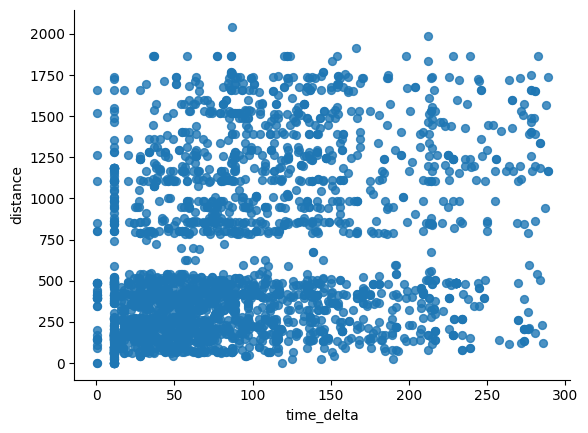

In [101]:
# @title time_delta vs distance

from matplotlib import pyplot as plt
df_sorted.plot(kind='scatter', x='time_delta', y='distance', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

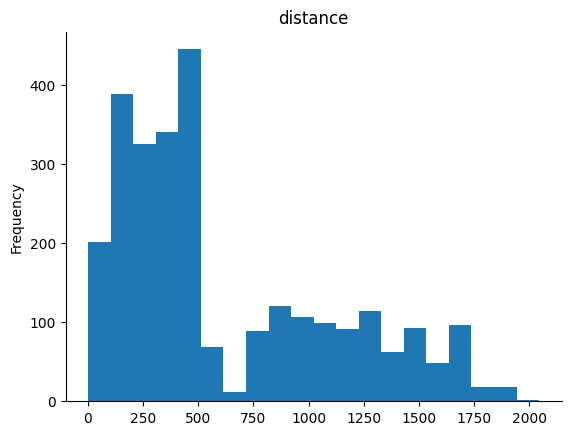

In [102]:
# @title distance

from matplotlib import pyplot as plt
df_sorted['distance'].plot(kind='hist', bins=20, title='distance')
plt.gca().spines[['top', 'right',]].set_visible(False)

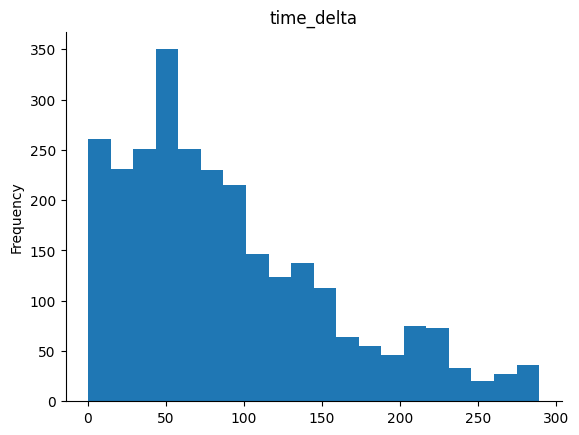

In [103]:
df_sorted['time_delta'].plot(kind='hist', bins=20, title='time_delta')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [104]:
diocese_stats_sorted.head(10000)

,diocese_11,diocese_11_label,time_delta,distance,event_count,diocese_lead_speed
333,https://g17.dhi-roma.it/resources/institution_697,Acquapendente,0.4,107.438598,1,11.692299
207,https://g17.dhi-roma.it/resources/institution_445,Parisiensis,11.0,1106.646166,2,0.637190
160,https://g17.dhi-roma.it/resources/institution_380,Milopotamiensis,11.0,1078.542365,1,0.634851
1,https://g17.dhi-roma.it/resources/institution_101,Basiliensis,11.0,739.374479,1,0.600528
142,https://g17.dhi-roma.it/resources/institution_351,Maceratensis,11.0,174.414197,3,0.469221
...,...,...,...,...,...,...
221,https://g17.dhi-roma.it/resources/institution_468,Portuensis,125.0,26.110419,1,0.026099
240,https://g17.dhi-roma.it/resources/institution_502,Sagonensis,222.0,314.147804,1,0.025900
223,https://g17.dhi-roma.it/resources/institution_470,Posnaniensis,288.0,1566.009247,1,0.025543
25,https://g17.dhi-roma.it/resources/institution_139,Cadurcensis,287.0,941.848319,1,0.023860


In [105]:
print("Events sorted by event lead speed:")
print(df_sorted[['event_label', 'event_lead_speed']])

print("\nDioceses sorted by diocese lead speed:")
print(diocese_stats_sorted[['diocese_11_label', 'diocese_lead_speed']])

Events sorted by event lead speed:
                   event_label  event_lead_speed
1158  APOSTOLIC PROVISION 4635       4146.264110
1002  APOSTOLIC PROVISION 4636       3793.780579
1504  APOSTOLIC PROVISION 4636       3161.638616
983   APOSTOLIC PROVISION 6911       2768.877733
559   APOSTOLIC PROVISION 3787       2123.426735
...                        ...               ...
2473  APOSTOLIC PROVISION 6260          0.127602
2569   APOSTOLIC PROVISION 607          0.127602
1433  APOSTOLIC PROVISION 5742          0.127602
1439   APOSTOLIC PROVISION 353          0.114032
2559  APOSTOLIC PROVISION 1329          0.022190

[2738 rows x 2 columns]

Dioceses sorted by diocese lead speed:
    diocese_11_label  diocese_lead_speed
333    Acquapendente           11.692299
207      Parisiensis            0.637190
160  Milopotamiensis            0.634851
1        Basiliensis            0.600528
142     Maceratensis            0.469221
..               ...                 ...
221       Portuensis     